# Homework #3

Due 11:59 pm EST, Wednesday March 9th, 2022.

Email your solutions (both .ipnb and .html files) to: compscbio@gmail.com.


### Background:

Your recent success in exploring cell cycle during directed differentiation has proven to be both a curse and a blessing. While it has raised your stature in the lab and department, it also means that expectations have also gone up. Accordingly, your PI has now asked you to analyze a data set from the lab of a colleague, who focuses on hematopoiesis.

You are asked to analyze scRNAseq data of hematopoietic stem/progenitor cells isolated from the bone marrow of old and young mice. You have done some background reading [Beerman et al 2010](https://pubmed.ncbi.nlm.nih.gov/20650622/) and learned that old mice tend to have fewer erythrocytes than young mice. In this project, you will perform trajectory inference analysis to try to understand why this might be the case. 

More background reading [Pietras et al Cell Stem Cell 2015](https://pubmed.ncbi.nlm.nih.gov/26095048/) explains the various sub-populations of the sequenced population (Lineage-, Sca-1+, Kit+ or LSK cells): 

<figure>
    <img src="img/LSKs.png" width=150>
    <figcaption>LSK sub-populations. Figure credit: Pietras et al 2015</figcaption>
</figure>

This tells you that you should focus on MPP2 and its progeny in your analysis. Fortunately, a well-annotated reference data set has been made available to you (see below), which you think you can use to identify the sub-populations to exclude superfluous cells.

You have also gleaned some gene sets that are preferentially expressed in different lineages as follows:

- Hematopoietic stem and progenitors: Procr, Mllt3, Hlf, Fgd5, Hoxa9
- Megakaryocyte progenitors: Pf4, Itga2b
- Erythroid progenitors: Klf1, Gata1, Epor


### The data
[Reference scRNAseq in the form of an h5ad file](https://compstemcellbio.s3.amazonaws.com/2022/homework/03/adHSC_reference_030222.h5ad)
This is the raw counts data. The cell type annotation is in `.obs["cell_type"]`. This data was derived originally from [Tikhonova et al Nature 2019](https://pubmed.ncbi.nlm.nih.gov/30971824/).

[scRNAseq of young LSKs](https://compstemcellbio.s3.amazonaws.com/2022/homework/03/adYoungHSC_03022022.h5ad)
Raw counts data from LSK cells of young mice. This data and that from the old animals (below) was derived from [Herault et al BMC Bio 2021](https://pubmed.ncbi.nlm.nih.gov/33526011/).

[scRNAseq of old LSKs](https://compstemcellbio.s3.amazonaws.com/2022/homework/03/adOldHSC_03022022.h5ad)
Raw counts data from LSK cells of old mice.


### Your mission: Part 1

Use the provided reference data to assign putative identities to your data.

Option 1: Use [PySingleCellNet](https://github.com/pcahan1/PySingleCellNet) to train a classifier, validate it on held out data, and apply it to your collaborator's data to infer cell types. Note that you *should not* clean or normalize the reference data prior to training the classifier.

Option 2: Use the annotated reference data to generate gene sets that mark each LSK sub-population. Then, use these gene sets to score your collaborator's data to infer cell types.

In [1]:
# Part 1 code, figures and explanatory text goes here and in subsequent cells. Show all code.

In [2]:
# !pip install git+https://github.com/pcahan1/PySingleCellNet/

In [3]:
# import dependencies
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns 
import scanpy as sc
import scipy as sp
import numpy as np
import pySingleCellNet as pySCN
sc.set_figure_params(dpi = 160 )

In [4]:
# lets try option 1
# load in the training/ref data
adTrain = sc.read("adHSC_reference_030222.h5ad")
adTrain

AnnData object with n_obs × n_vars = 1929 × 14790
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_mt', 'pct_counts_mt', 'cellid', 'cell_type'
    var: 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

In [5]:
# load in young HSC data
adYoung = sc.read('adYoungHSC_03022022.h5ad')
adYoung

AnnData object with n_obs × n_vars = 2500 × 28692
    obs: 'age', 'sample', 'cellid'
    var: 'gene_ids'

In [6]:
# load in old HSC data 
adOld = sc.read('adOldHSC_03022022.h5ad')
adOld

AnnData object with n_obs × n_vars = 2500 × 28692
    obs: 'age', 'sample', 'cellid'
    var: 'gene_ids'

### Look at var names aka gene names

In [7]:
# reference/training
adTrain.var_names

Index(['0610007P14Rik', '0610009B22Rik', '0610009L18Rik', '0610009O20Rik',
       '0610010F05Rik', '0610010K14Rik', '0610011F06Rik', '0610012G03Rik',
       '0610030E20Rik', '0610037L13Rik',
       ...
       'Zufsp', 'Zw10', 'Zwilch', 'Zwint', 'Zxdb', 'Zxdc', 'Zyg11b', 'Zyx',
       'Zzef1', 'Zzz3'],
      dtype='object', length=14790)

In [8]:
# young
adYoung.var_names

Index(['Xkr4', 'Gm1992', 'Gm37381', 'Rp1', 'Rp1-1', 'Sox17', 'Gm37323',
       'Mrpl15', 'Lypla1', 'Gm37988',
       ...
       'AC125149.1', 'AC125149.2', 'AC125149.4', 'AC234645.1', 'AC168977.2',
       'AC168977.1', 'PISD', 'DHRSX', 'Vmn2r122', 'CAAA01147332.1'],
      dtype='object', length=28692)

In [9]:
# old
adOld.var_names

Index(['Xkr4', 'Gm1992', 'Gm37381', 'Rp1', 'Rp1-1', 'Sox17', 'Gm37323',
       'Mrpl15', 'Lypla1', 'Gm37988',
       ...
       'AC125149.1', 'AC125149.2', 'AC125149.4', 'AC234645.1', 'AC168977.2',
       'AC168977.1', 'PISD', 'DHRSX', 'Vmn2r122', 'CAAA01147332.1'],
      dtype='object', length=28692)

In [10]:
# are the gene names the same for both young and old HSC's
list(adYoung.var_names) == list(adOld.var_names)

True

In [11]:
# since the gene names are the same for young and old HSC's we can use one of them to find the overlap with the reference
genesTrain = adTrain.var_names
genesQuery = adYoung.var_names

# let's see how many genes overlap
cgenes = genesTrain.intersection(genesQuery)
len(cgenes)
# should be 14775

14775

In [12]:
# get n_genes_by_counts for both young and old
sc.pp.calculate_qc_metrics(adYoung, percent_top=None, log1p=False, inplace=True)
sc.pp.calculate_qc_metrics(adOld, percent_top=None, log1p=False, inplace=True)

In [13]:
# check that all cells have more than 500 genes for young HSC
print(len(adYoung.obs), len(adYoung.obs[adYoung.obs['n_genes_by_counts'] >= 500] ))

# all cells from young mice have n_gene_by_counts >= 500

2500 2500


In [14]:
# check that all cells have more than 500 genes for old HSC
print(len(adOld.obs), len(adOld.obs[adOld.obs['n_genes_by_counts'] >= 500]))

# all cells from old mice have n_gene_by_counts >= 500

2500 2500


In [15]:
# " When you train the classifier, you should ensure that the query data and the reference data are limited to a common set of genes. 
# In this case, we also limit the query data to those cells with at least 500 genes. "
# in this case it's all cells
adTrain1 = adTrain[:,cgenes]
adQuery = adYoung[:,cgenes].copy()
adQuery = adQuery[adQuery.obs["n_genes_by_counts"]>=500,:].copy()
adQuery

AnnData object with n_obs × n_vars = 2500 × 14775
    obs: 'age', 'sample', 'cellid', 'n_genes_by_counts', 'total_counts'
    var: 'gene_ids', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

In [16]:
# split ref data intro train and held out data
expTrain, expVal = pySCN.splitCommonAnnData(adTrain1, ncells=200,dLevel="cell_type")

Trying to set attribute `.obs` of view, copying.


BcellPr : 
50
MPP2 : 
500
MPP4 : 
500
EryPr : 
68
HSC : 
500
MonoPr : 
23
MPP3 : 
265
Unk : 
23


In [17]:
# train the classifier 
[cgenesA, xpairs, tspRF] = pySCN.scn_train(expTrain, nTopGenes = 100, nRand = 100, nTrees = 1000 ,nTopGenePairs = 100, 
                                           dLevel = "cell_type", stratify=True, limitToHVG=True)

HVG
Matrix normalized
There are  770  classification genes

BcellPr
EryPr
HSC
MPP2
MPP3
MPP4
MonoPr
Unk
There are 792 top gene pairs

Finished pair transforming the data



... storing 'SCN_class' as categorical


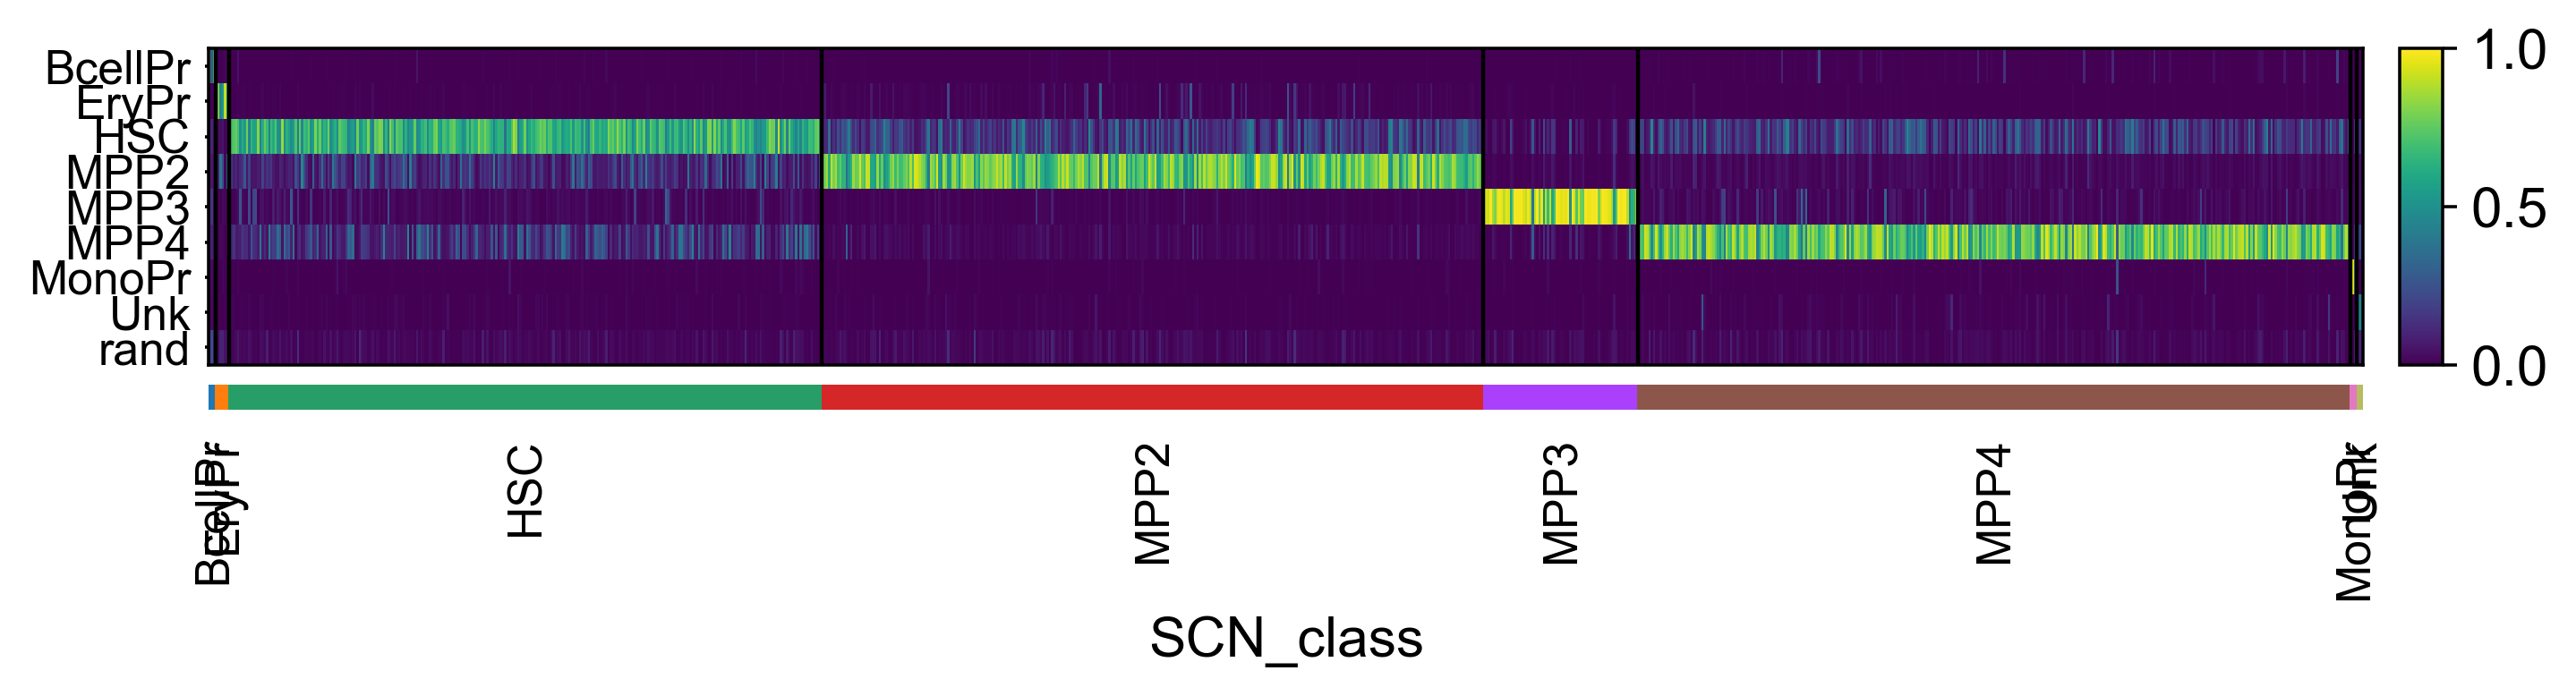

In [18]:
# classify held out data and visualize 
adVal = pySCN.scn_classify(expVal, cgenesA, xpairs, tspRF, nrand = 0)

# plot grouped by predicted cell label aka the cell type with the highest probability 
ax = sc.pl.heatmap(adVal, adVal.var_names.values, groupby='SCN_class', cmap='viridis', dendrogram=False, swap_axes=True)

... storing 'SCN_class' as categorical


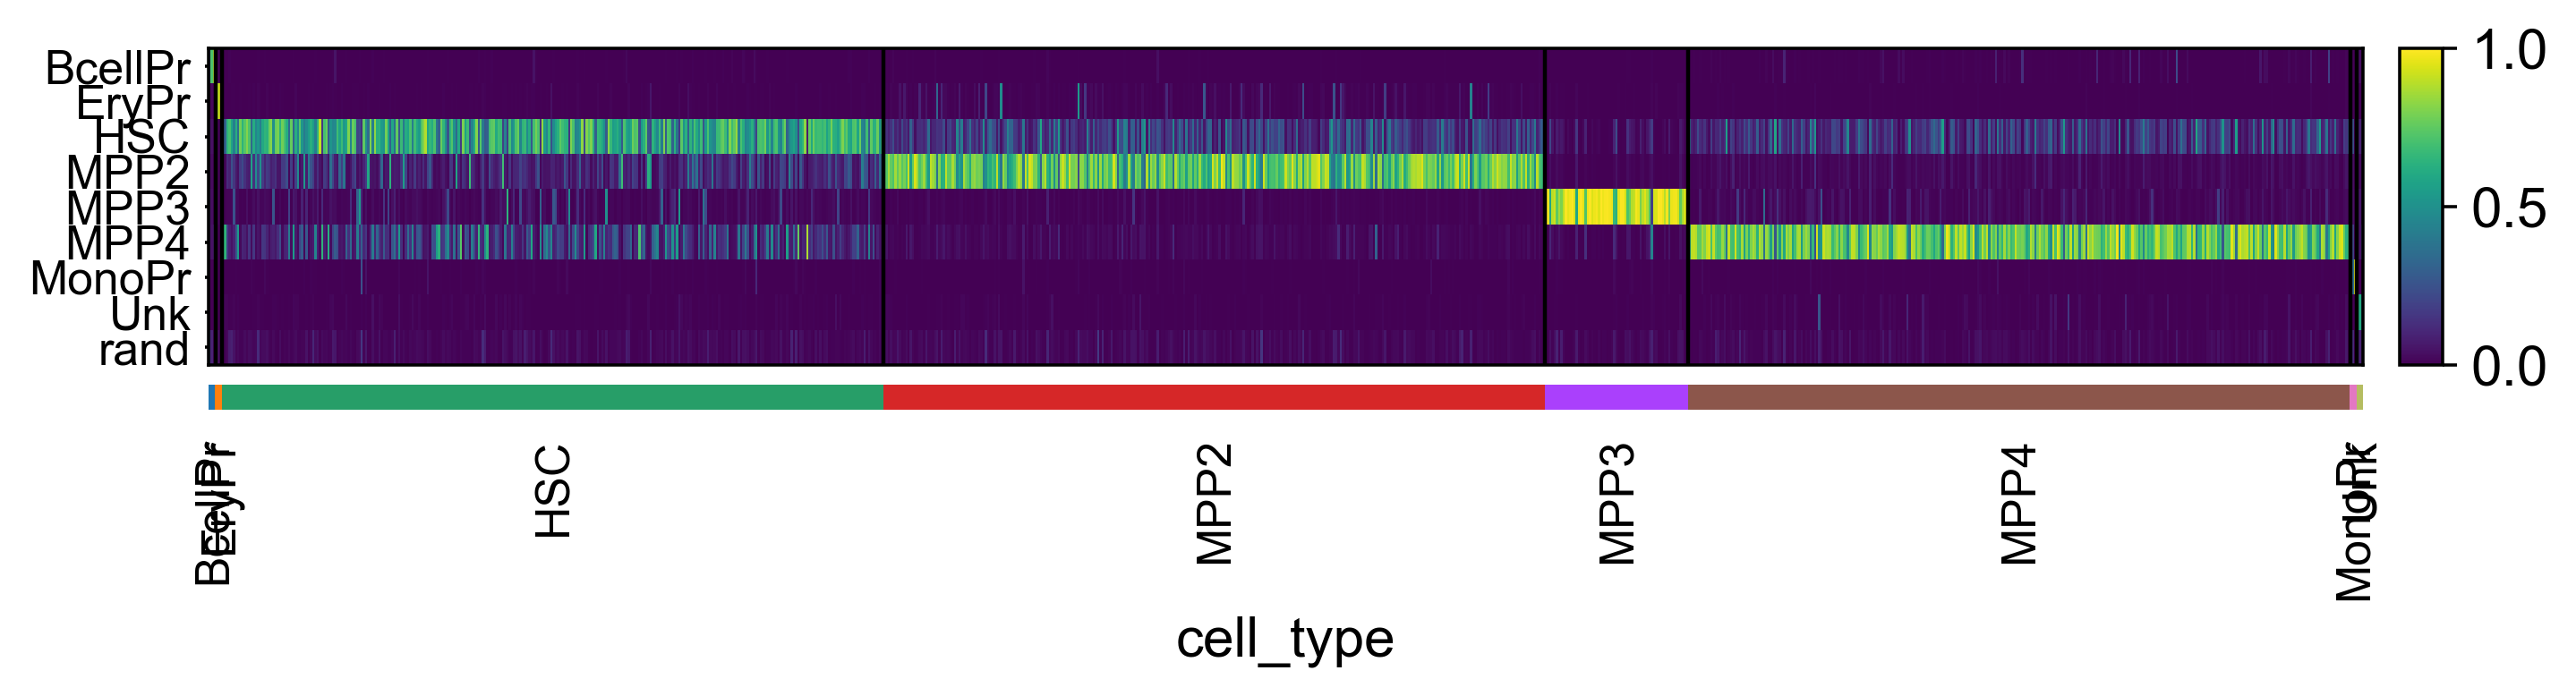

In [19]:
# classify held out data and visualize 
adVal = pySCN.scn_classify(expVal, cgenesA, xpairs, tspRF, nrand = 0)

# y axis is cell types in the classifier, x axis is true cell labels
ax = sc.pl.heatmap(adVal, adVal.var_names.values, groupby='cell_type', cmap='viridis', dendrogram=False, swap_axes=True)

# in my opinion this heat map looks pretty similar to the previous one 

In [20]:
adVal

AnnData object with n_obs × n_vars = 977 × 9
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_mt', 'pct_counts_mt', 'cellid', 'cell_type', None, 'SCN_class'
    uns: 'cell_type_colors'

In [21]:
expTrain

View of AnnData object with n_obs × n_vars = 952 × 14775
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_mt', 'pct_counts_mt', 'cellid', 'cell_type', None
    var: 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

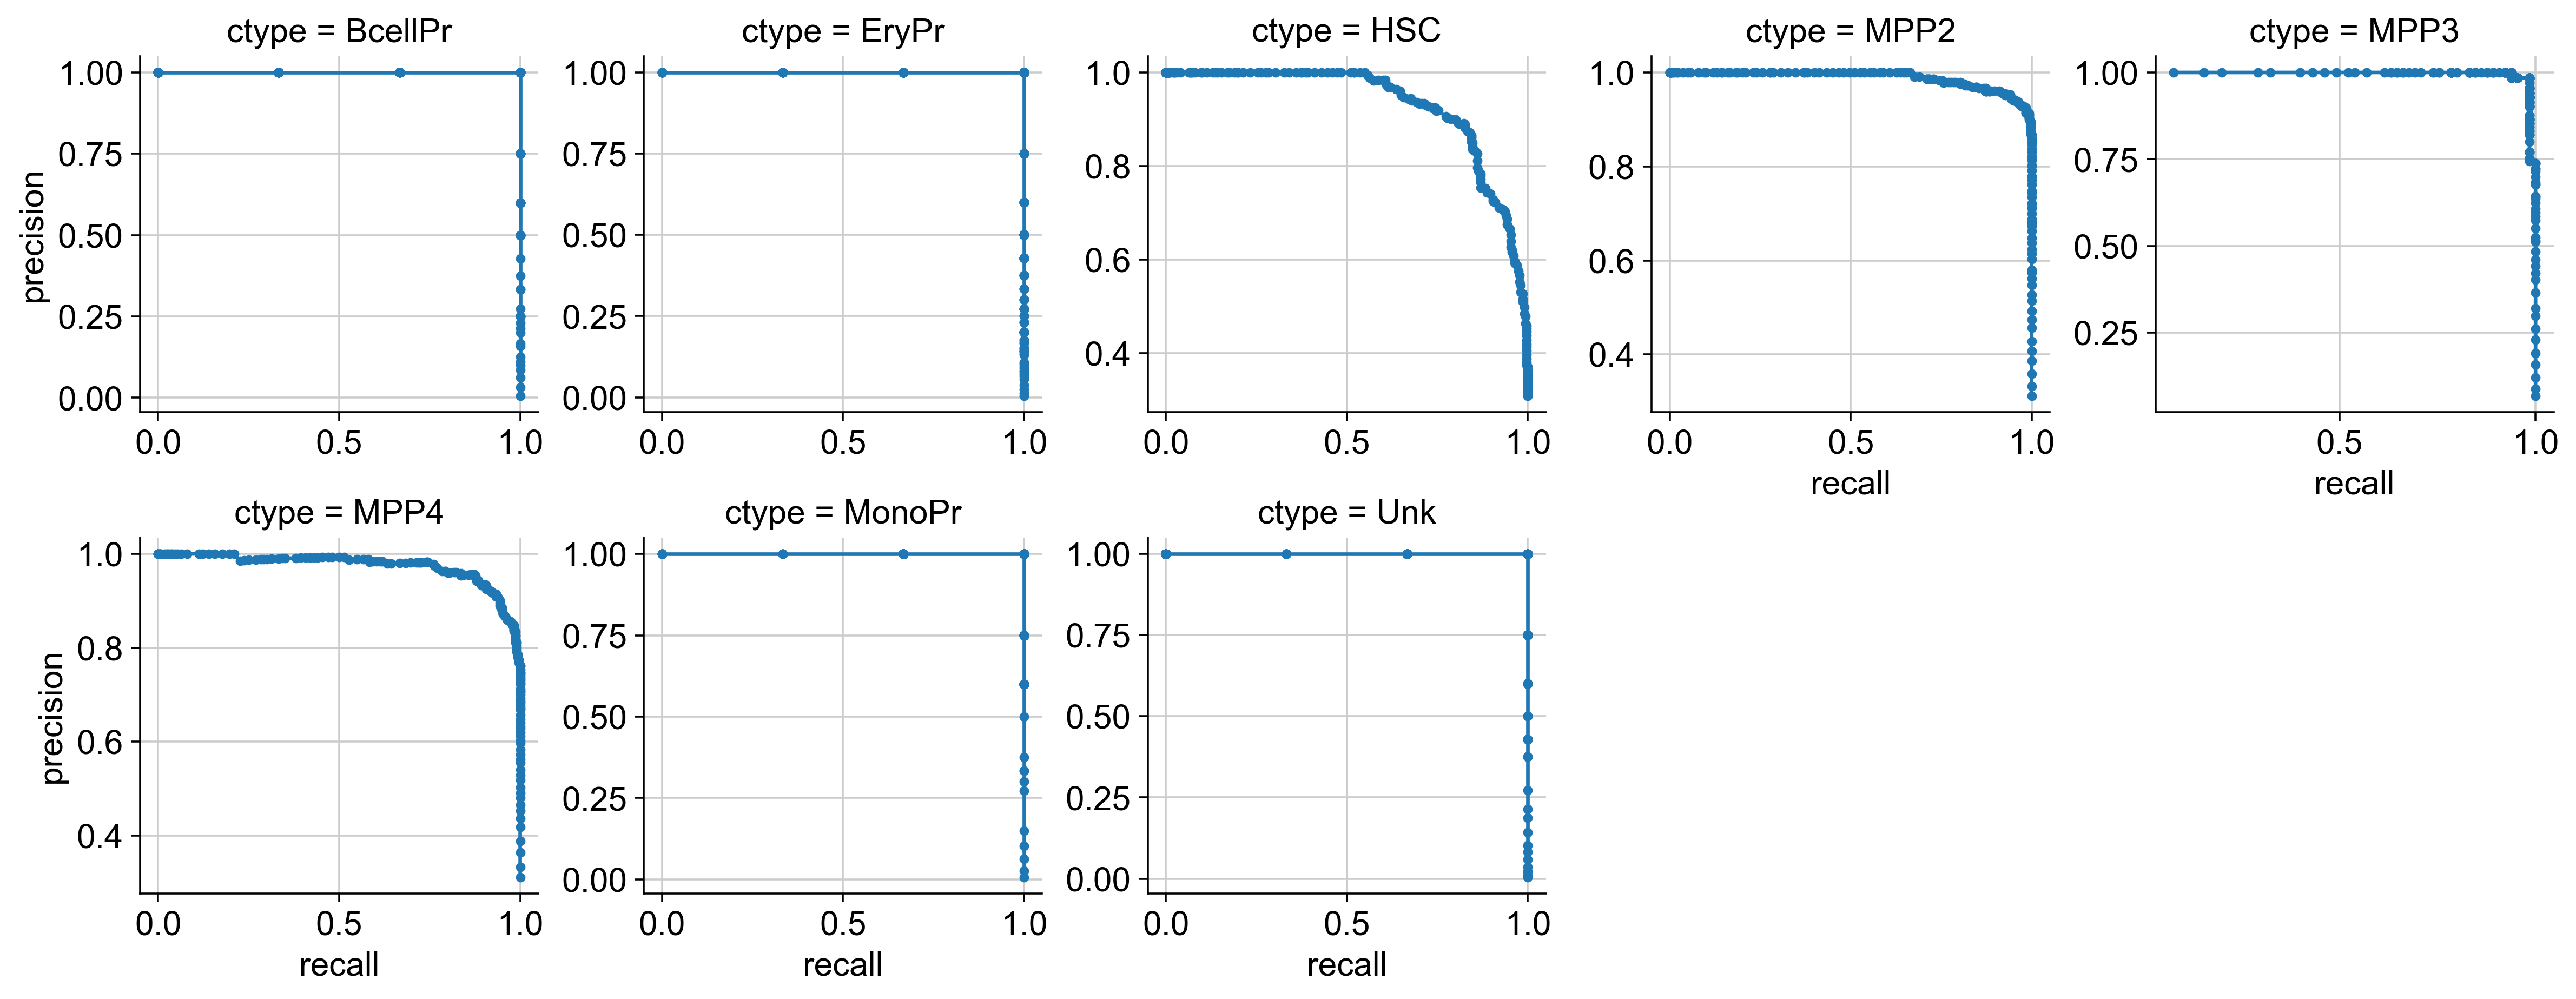

In [22]:
# determine how well classifier predicts cell types of held out data and visualize 
assessment =  pySCN.assess_comm(expTrain, adVal, resolution = 0.005, nRand = 0, dLevelSID = "cellid", classTrain = "cell_type", classQuery = "cell_type")
pySCN.plot_PRs(assessment)
plt.show()

# these curves look pretty good, we want precision to be as high as possible 
# area under most of these curves look close to 1, which means our classifier is pretty good

In [23]:
# try to demonstrate MLC worked well, print accuracy 
print('Accuracy:', assessment['accuracy'])

Accuracy: 0.9129989764585466


In [24]:
# counts of each classifier predcited cell type
adVal.obs.value_counts('SCN_class')

SCN_class
MPP4       323
MPP2       300
HSC        269
MPP3        70
EryPr        6
BcellPr      3
MonoPr       3
Unk          3
dtype: int64

In [25]:
# counts of each true cell type
adVal.obs.value_counts('cell_type')

cell_type
HSC        300
MPP2       300
MPP4       300
MPP3        65
BcellPr      3
EryPr        3
MonoPr       3
Unk          3
dtype: int64

In [1253]:
# handling rand cuz we cant compare if they categories are different 
# sometimes SCN_class will have a rand and the code in the cell below will break, so we have to iterate through 
# lets see how many cells have matching labels
match = 0 
for i in range(0, len(adVal.obs)):
    if(adVal.obs['cell_type'][i] == adVal.obs['SCN_class'][i]):
        match+=1

# total cells vs how many were correctly classified
len(adVal.obs), match

(977, 892)

In [27]:
# # breaks if SCN_val has a rand
# # how many classifier gets right vs total # of cells
# sum(adVal.obs['cell_type'] == adVal.obs['SCN_class']), len(adVal.obs)

In [28]:
# output % of cells our classifier correctly predicted
print('Our classifier correctly predicts', "{:.2f}".format(match / len(adVal.obs) * 100, 2),
      '% of cells for cell type for our validation data')

Our classifier correctly predicts 91.30 % of cells for cell type for our validation data


### Classify our query data
Start with the young HSC's

... storing 'SCN_class' as categorical


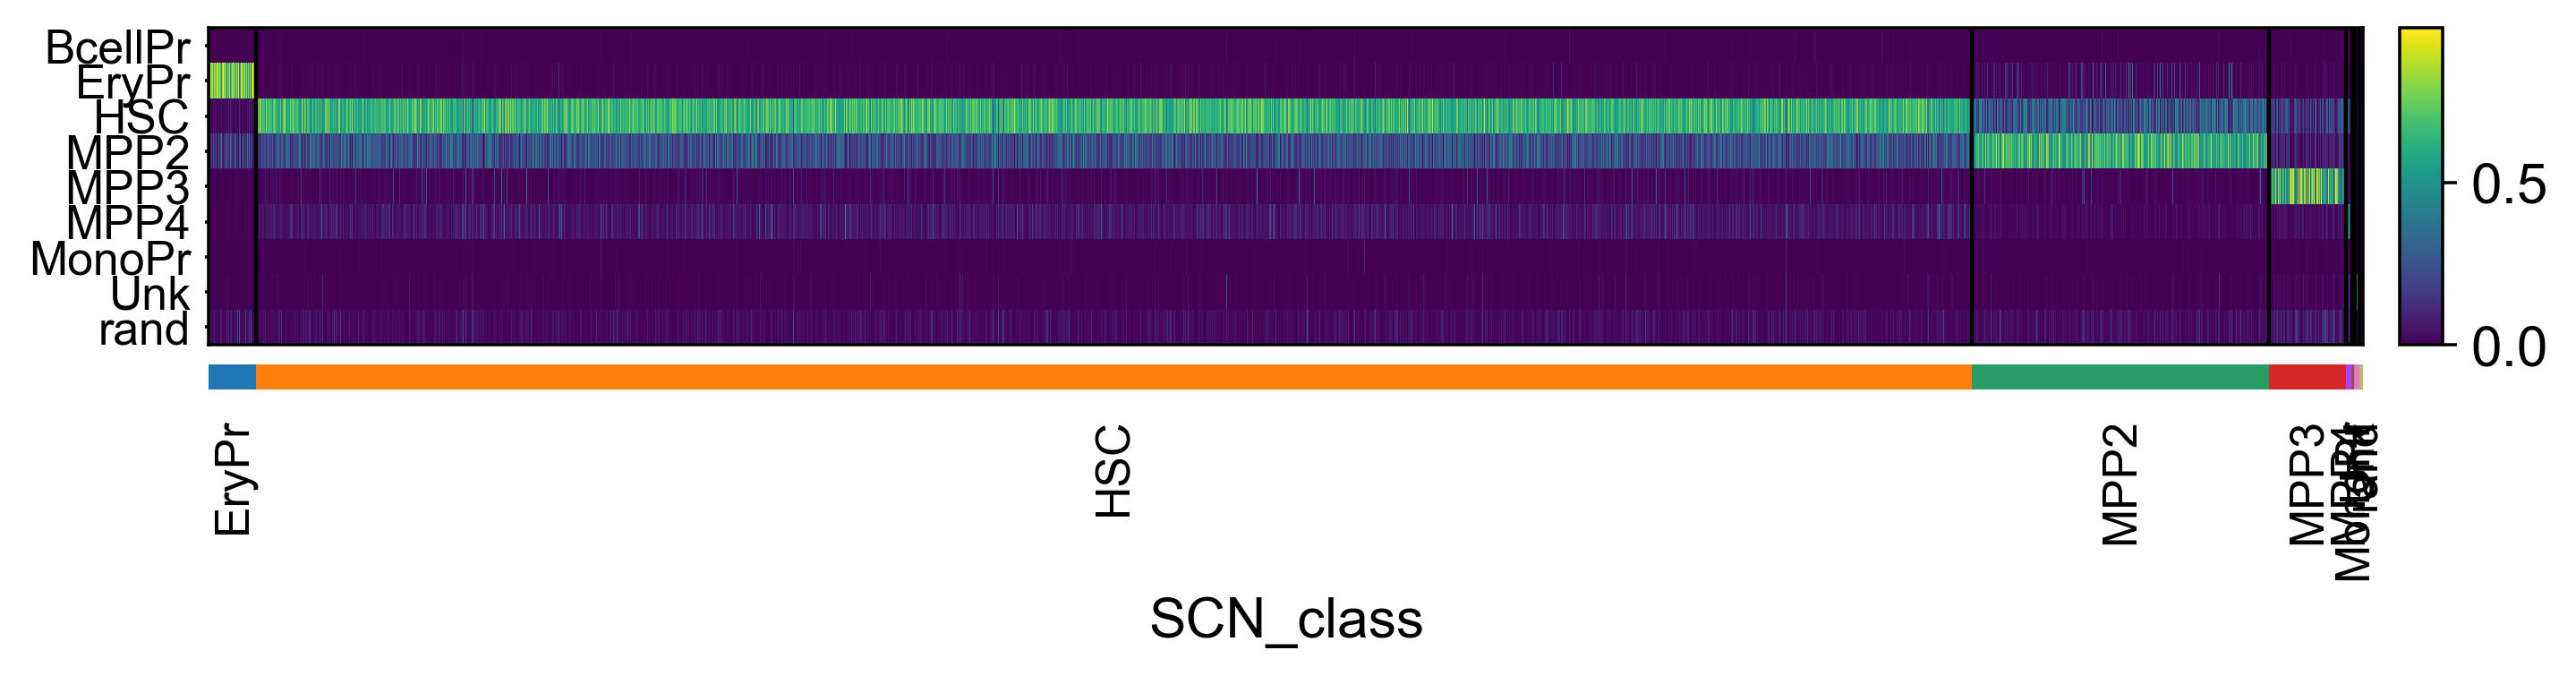

In [29]:
# classifiy independent query data
# currently its the young HSC
adQYoung = pySCN.scn_classify(adQuery, cgenesA, xpairs, tspRF, nrand = 0)

ax = sc.pl.heatmap(adQYoung, adQYoung.var_names.values, groupby='SCN_class', cmap='viridis', dendrogram=False, swap_axes=True)

In [30]:
# predicted cell types for young hsc's
adQYoung.obs['SCN_class']

AAACCTGCAATCGGTT-1    HSC
AAACCTGCACGGATAG-1    HSC
AAACCTGCATCTACGA-1    HSC
AAACCTGCATTCACTT-1    HSC
AAACCTGGTATAGTAG-1    HSC
                     ... 
TTTGGTTTCTACGAGT-1    HSC
TTTGTCACAAGGGTCA-1    HSC
TTTGTCAGTCGGGTCT-1    HSC
TTTGTCATCTATCCTA-1    HSC
TTTGTCATCTGCTTGC-1    HSC
Name: SCN_class, Length: 2500, dtype: category
Categories (8, object): ['EryPr', 'HSC', 'MPP2', 'MPP3', 'MPP4', 'MonoPr', 'Unk', 'rand']

### Classify the old HSC's

In [31]:
# classify for old HSC
adQueryOld = adOld[:,cgenes].copy()
adQueryOld = adQueryOld[adQueryOld.obs["n_genes_by_counts"]>=500,:].copy()
adQueryOld # genes are the same as adYoung as we proved before

AnnData object with n_obs × n_vars = 2500 × 14775
    obs: 'age', 'sample', 'cellid', 'n_genes_by_counts', 'total_counts'
    var: 'gene_ids', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

... storing 'SCN_class' as categorical


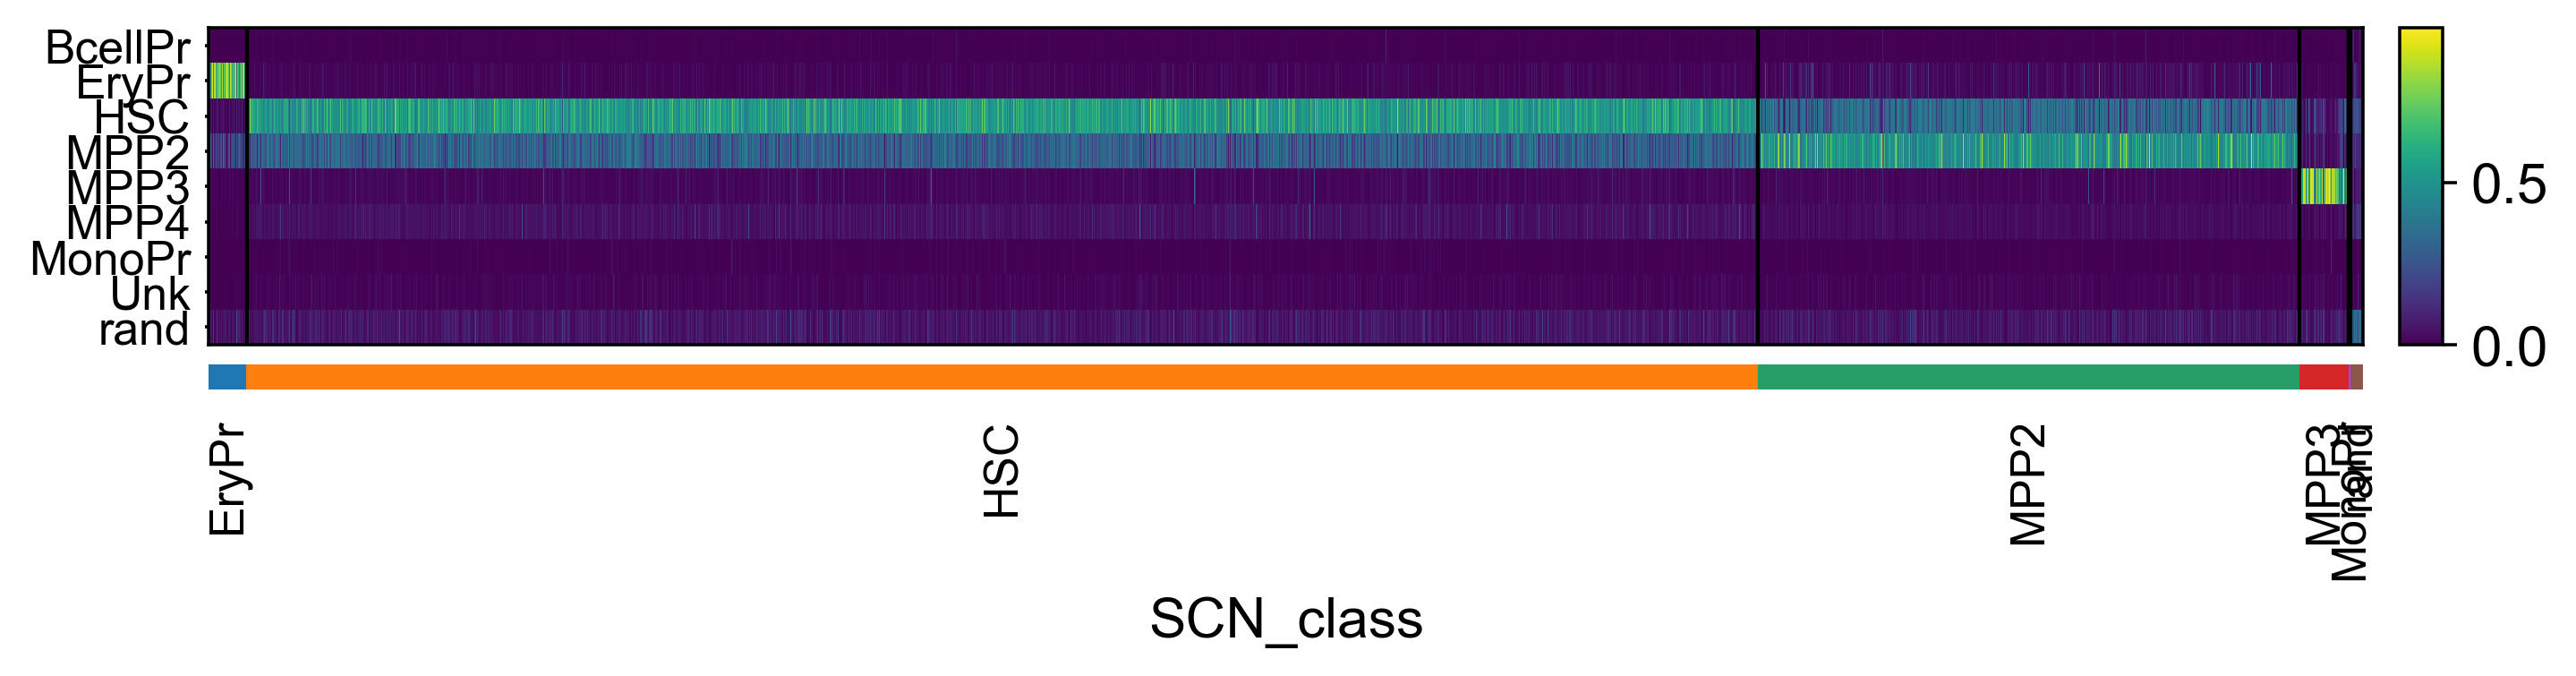

In [32]:
# classifiy independent query data
# currently its the old HSC
adQOld = pySCN.scn_classify(adQueryOld, cgenesA, xpairs, tspRF, nrand = 0)

ax = sc.pl.heatmap(adQOld, adQOld.var_names.values, groupby='SCN_class', cmap='viridis', dendrogram=False, swap_axes=True)

In [33]:
# predicted cell types for old hsc's
adQOld.obs['SCN_class']

AAACCTGCAGATGGCA-1     HSC
AAACCTGCATGGATGG-1     HSC
AAACCTGGTCCGAGTC-1    MPP2
AAACCTGGTGGCTCCA-1     HSC
AAACCTGTCGAATGCT-1     HSC
                      ... 
TTTGTCAAGACACGAC-1     HSC
TTTGTCAAGGCCCTTG-1     HSC
TTTGTCAAGTGGCACA-1     HSC
TTTGTCACACGAAACG-1     HSC
TTTGTCAGTATAGTAG-1    MPP2
Name: SCN_class, Length: 2500, dtype: category
Categories (6, object): ['EryPr', 'HSC', 'MPP2', 'MPP3', 'MonoPr', 'rand']

### Your mission: Part 2

Perform trajectory analysis on each data set separately (but not on the reference data). Be careful to exclude superfluous cells prior to analysis. In other words, only use MPP2 and EryPr cells. Use `diffmap`, and judiciously illustrate the DCs that reflect differentiation.

In [34]:
# Part 2 code, figures and explanatory text goes here and in subsequent cells. Show all code.

Like before, we will start with the young hsc's

In [995]:
# filter for only the 2 cell types MPP2 and EryPr, we use SCN_class to subset our Young mouse data
adYoung_filt = adYoung[(adQYoung.obs['SCN_class'] == 'MPP2') | (adQYoung.obs['SCN_class'] == 'EryPr')]
adYoung_filt.obs # only cells with predicted type MPP2 and EryPr

age   sample              cellid  n_genes_by_counts  \
AAACGGGAGCTGCAAG-1  young  young_A  AAACGGGAGCTGCAAG-1               3967   
AAACGGGCAGTAAGCG-1  young  young_A  AAACGGGCAGTAAGCG-1               3753   
AAACGGGGTCCTAGCG-1  young  young_A  AAACGGGGTCCTAGCG-1               4959   
AAACGGGTCTTGTTTG-1  young  young_A  AAACGGGTCTTGTTTG-1               2698   
AAAGTAGGTCAGAATA-1  young  young_A  AAAGTAGGTCAGAATA-1               3080   
...                   ...      ...                 ...                ...   
TTGCGTCGTCAAACTC-1  young  young_A  TTGCGTCGTCAAACTC-1               2581   
TTGGAACAGGAATCGC-1  young  young_A  TTGGAACAGGAATCGC-1               2284   
TTGGAACTCTTTACGT-1  young  young_A  TTGGAACTCTTTACGT-1               2102   
TTGTAGGTCTGTCTAT-1  young  young_A  TTGTAGGTCTGTCTAT-1               2596   
TTTGCGCCAGATAATG-1  young  young_A  TTTGCGCCAGATAATG-1               3350   

                    total_counts  
AAACGGGAGCTGCAAG-1       15381.0  
AAACGGGCAGTAAGCG-1       13371.0  
AAACGGGGTCCTAGCG-1       26082.0  
AAACGGGTCTTGTTTG-1        8196.0  
AAAGTAGGTCAGAATA-1       10263.0  
...                          ...  
TTGCGTCGTCAAACTC-1        6775.0  
TTGGAACAGGAATCGC-1        5888.0  
TTGGAACTCTTTACGT-1        6366.0  
TTGTAGGTCTGTCTAT-1        7635.0  
TTTGCGCCAGATAATG-1       11401.0  

[400 rows x 5 columns]

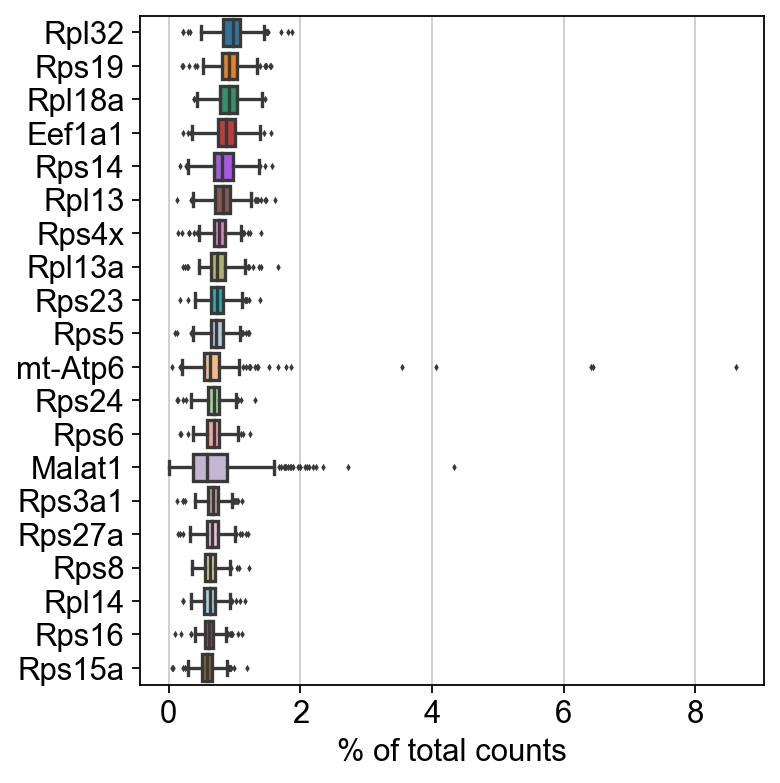

In [996]:
# let's see what the highest expression is like
sc.pl.highest_expr_genes(adYoung_filt, n_top=20, )

In [997]:
# preprocessing view ribo and mt expression
adYoung_filt.var['mt']= adYoung_filt.var_names.str.startswith(("mt-"))
adYoung_filt.var['ribo'] = adYoung_filt.var_names.str.startswith(("Rps","Rpl"))
sc.pp.calculate_qc_metrics(adYoung_filt, qc_vars=['ribo', 'mt'], percent_top=None, log1p=False, inplace=True)

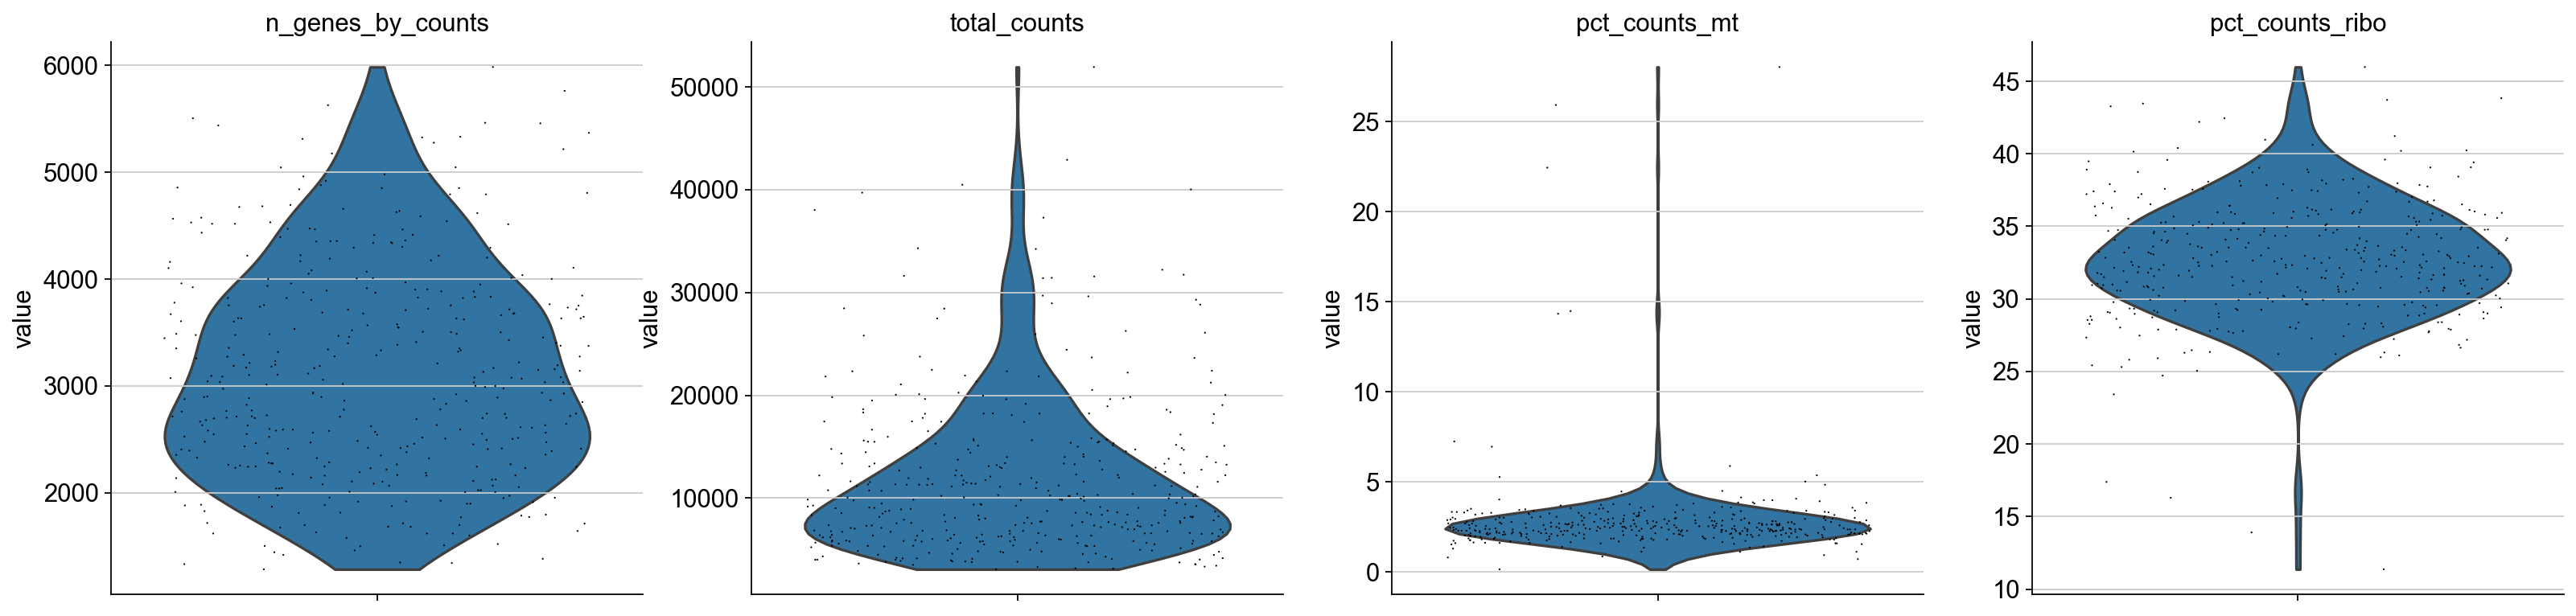

In [998]:
# violin plot to view ribo and mt %
axs = sc.pl.violin(adYoung_filt, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'pct_counts_ribo'],jitter=0.4, multi_panel=True)

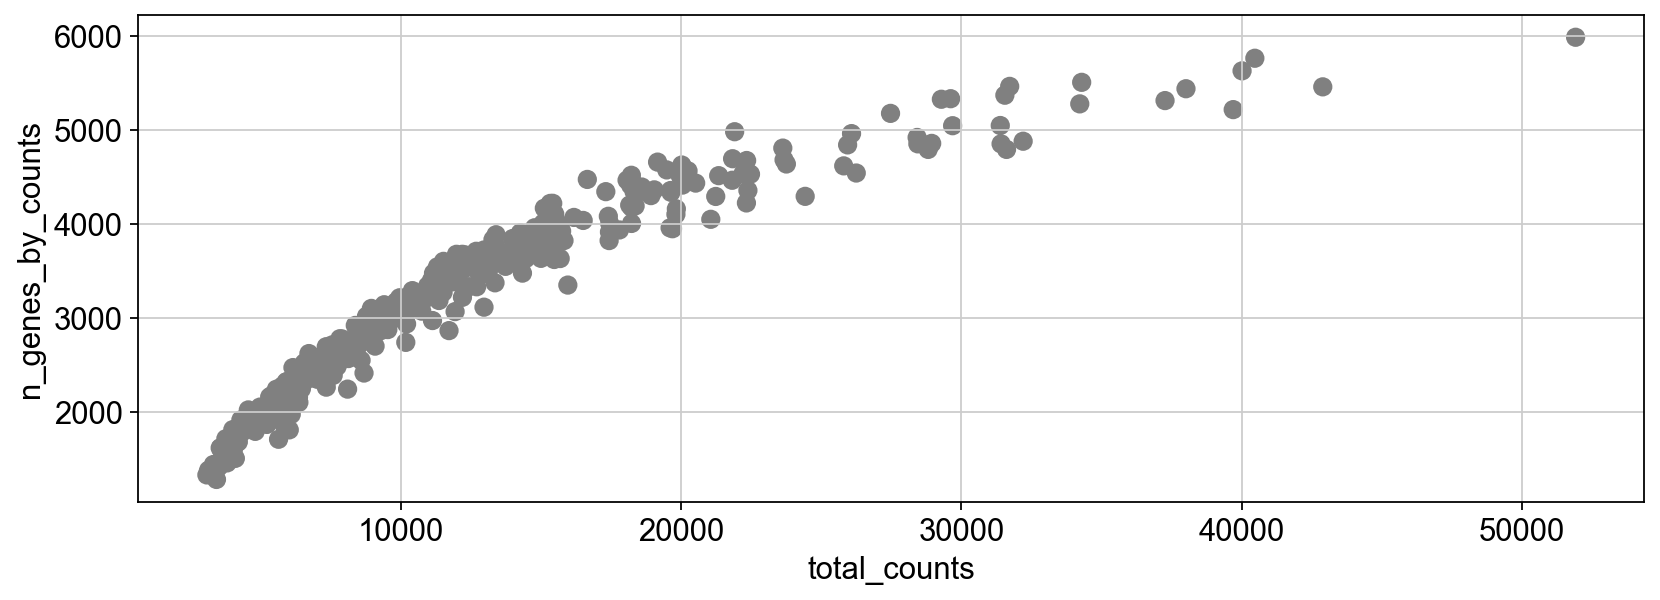

In [999]:
# view total counts vs n genes by counts
sc.pl.scatter(adYoung_filt, x='total_counts', y='n_genes_by_counts')

In [1000]:
# only mt and total count look like they have some value that are too high so lets remove them
# try to target the excess 'tips'
adYoung_filt = adYoung_filt[adYoung_filt.obs['total_counts'] < 50000, :]
adYoung_filt = adYoung_filt[adYoung_filt.obs['pct_counts_mt'] < 10, :]

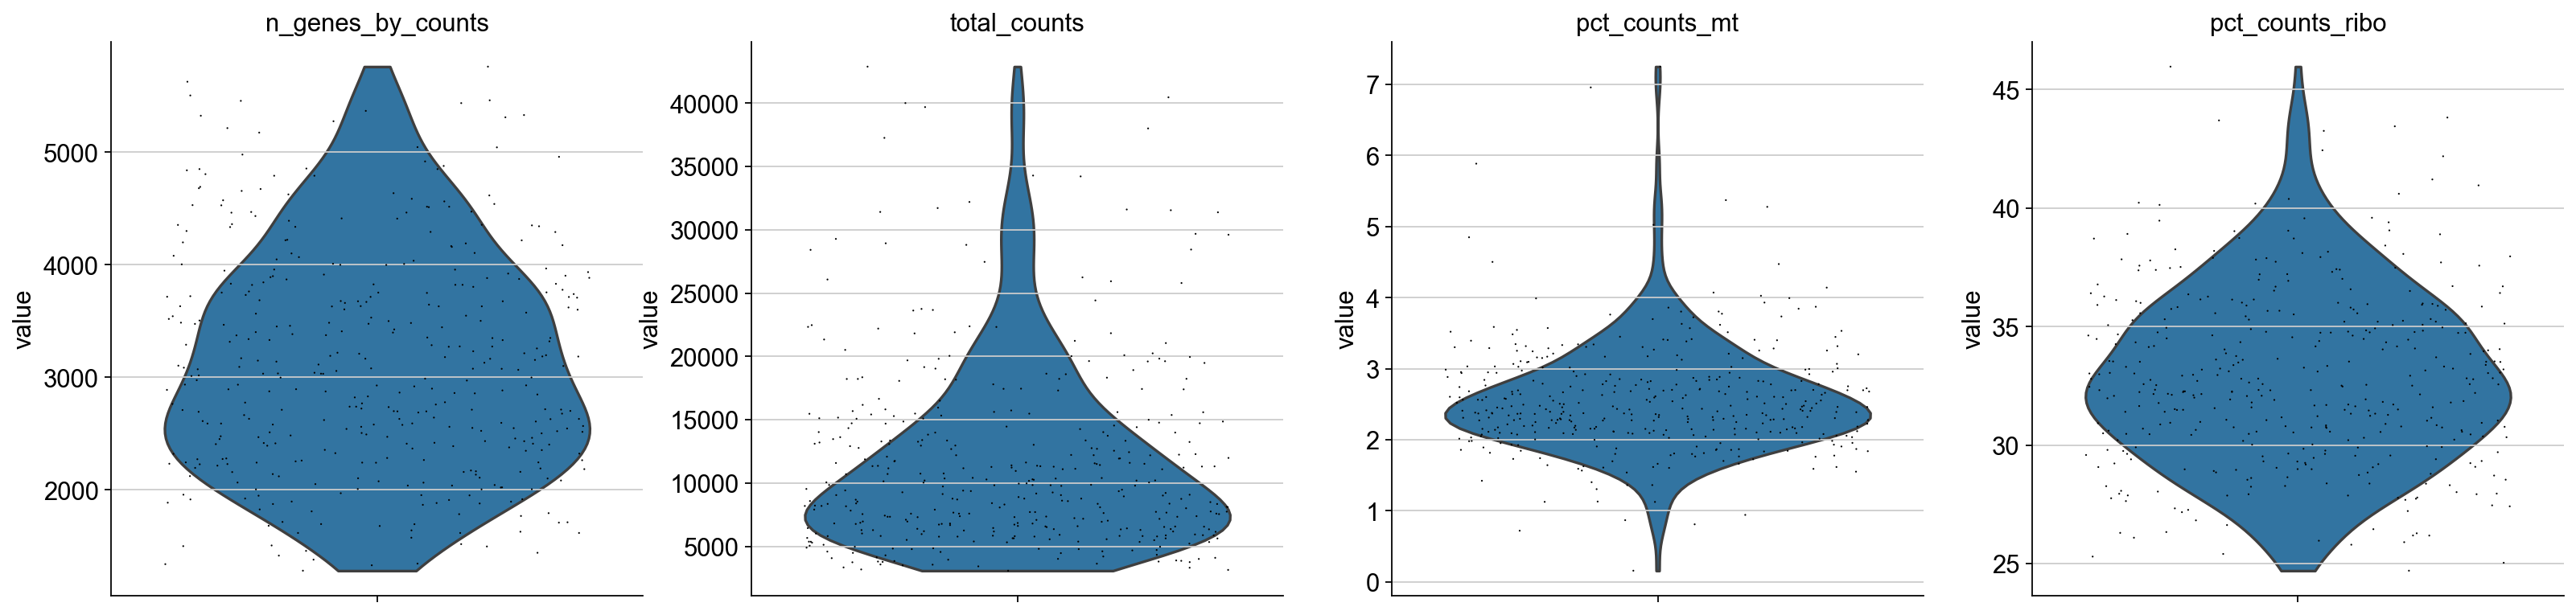

In [1001]:
# replot to view filtered data
axs = sc.pl.violin(adYoung_filt, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'pct_counts_ribo'],jitter=0.4, multi_panel=True)

In [1002]:
# remove potential doublets 
print("Number of cells: ",adYoung_filt.n_obs)

# figure out the total counts == 98 percentile
thresh = np.percentile(adYoung_filt.obs['total_counts'],98) # 98% since we have 2500 total cells recovered, accoding to 10x chart
print("98th percentile: ",thresh)

adYoung_filt = adYoung_filt[adYoung_filt.obs['total_counts'] < thresh, :]
print("Number of cells: ",adYoung_filt.n_obs)

Number of cells:  394
98th percentile:  32486.799999999974
Number of cells:  386


In [1003]:
# remove bad genes 
mito_genes = adYoung_filt.var_names.str.startswith('mt-')
ribo_genes = adYoung_filt.var_names.str.startswith(("Rpl","Rps"))
malat_gene = adYoung_filt.var_names.str.startswith("Malat1")

remove = np.add(mito_genes, ribo_genes)
remove = np.add(remove, malat_gene)
keep = np.invert(remove)

print('# of genes to remove:', len(keep) - np.count_nonzero(keep))

adYoung_filt = adYoung_filt[:,keep].copy()
print("Number of genes: ",  adYoung_filt.n_vars)

# of genes to remove: 127
Number of genes:  28565


In [1004]:
adYNorm = adYoung_filt.copy()
# filter for genes that are in atleast 5 cells
sc.pp.filter_genes(adYNorm, min_cells=5)

# normalize
sc.pp.normalize_per_cell(adYNorm, counts_per_cell_after=1e4)

# log transform 
sc.pp.log1p(adYNorm)

# ID HVG's
sc.pp.highly_variable_genes(adYNorm, min_mean=0.0125, max_mean=5, min_disp=0.25)

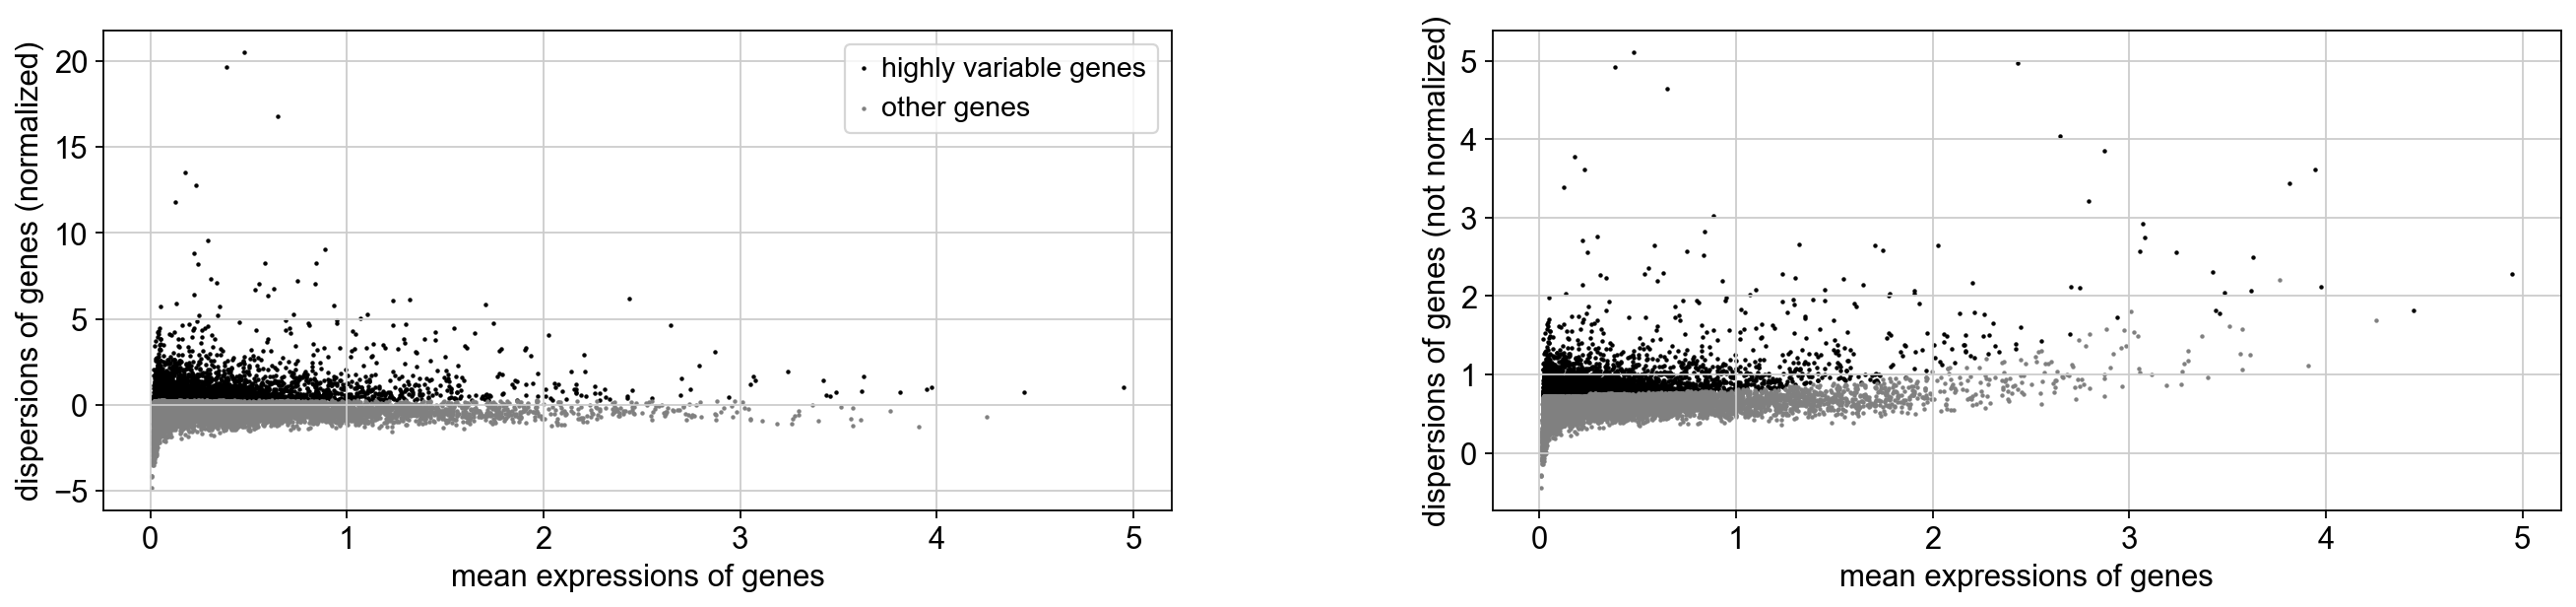

In [1005]:
sc.pl.highly_variable_genes(adYNorm)

In [1006]:
adYNorm.raw = adYNorm
# scale
sc.pp.scale(adYNorm, max_value=10)

# compute pca
sc.tl.pca(adYNorm, n_comps=100)

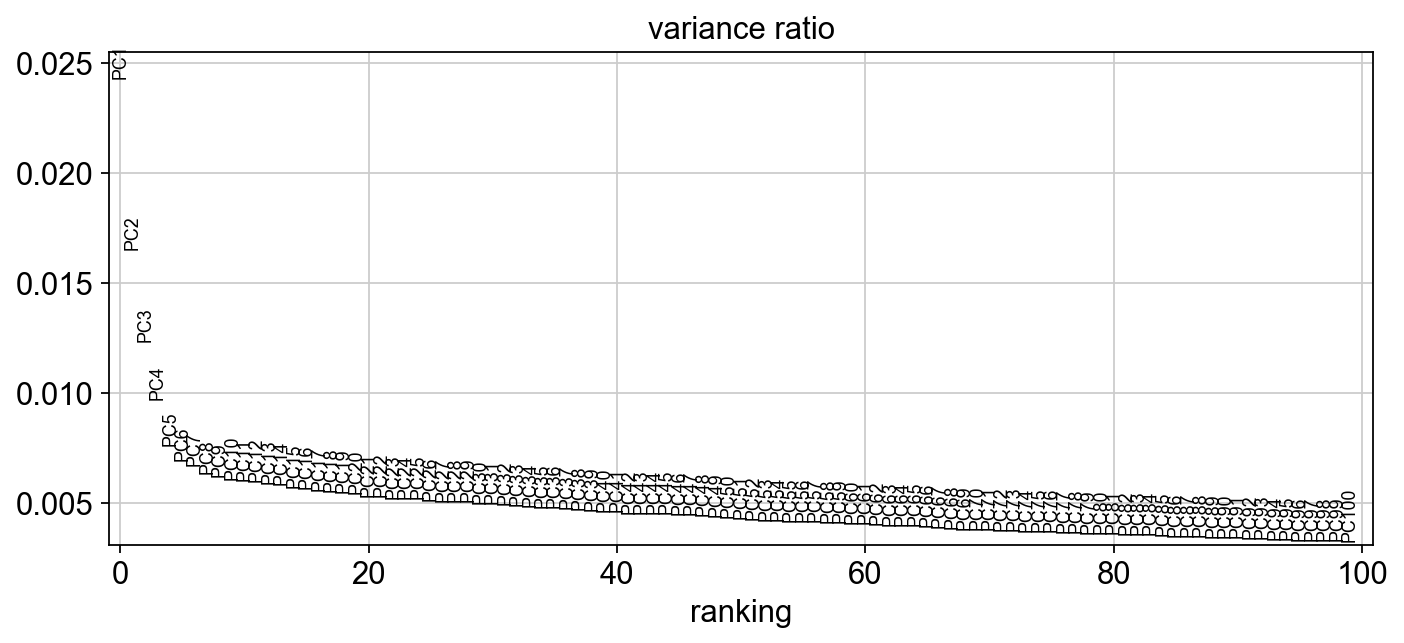

In [1007]:
# plot signif of each pc
sc.set_figure_params(figsize="10, 4")
sc.pl.pca_variance_ratio(adYNorm, 100)

In [1151]:
# perform leiden to try to see different cell types
npcs = 60
nknns = 11
sc.pp.neighbors(adYNorm, n_neighbors=nknns, n_pcs=npcs)
sc.tl.leiden(adYNorm,.25)

<AxesSubplot:title={'center':'leiden'}, xlabel='PC1', ylabel='PC3'>

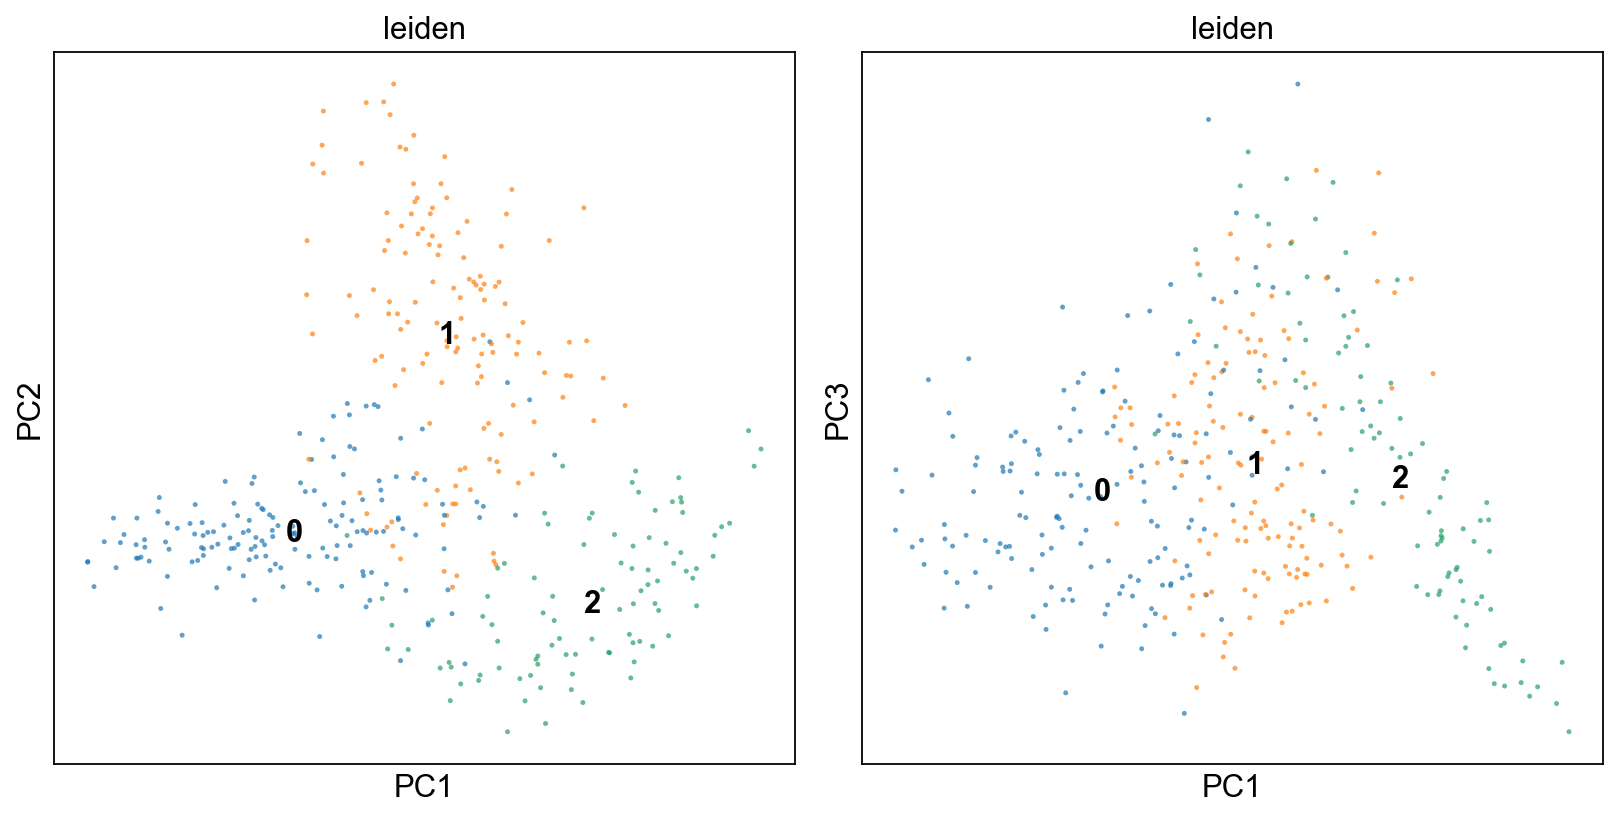

In [1152]:
# plot pca colored by leiden, we can see 3 clusterse
fig, axs = plt.subplots(1,2, figsize=(10,5), constrained_layout=True)
sc.pl.pca(adYNorm, color=["leiden"], alpha=.7, s=20, components="1,2",legend_loc='on data', ax=axs[0], show=False)
sc.pl.pca(adYNorm, color=["leiden"], alpha=.7, s=20, components="1,3",legend_loc='on data', ax=axs[1], show=False)

In [1153]:
# rank the genes in each leiden cluster
sc.tl.rank_genes_groups(adYNorm, 'leiden', use_raw=False)

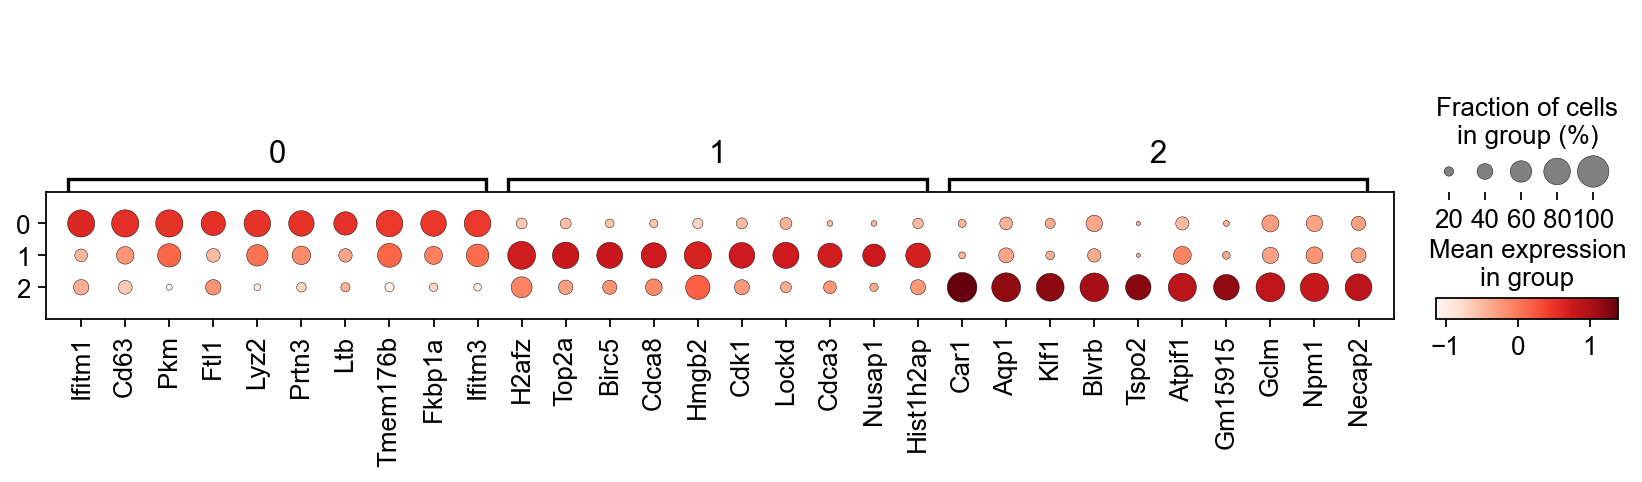

In [1154]:
# plot to view top n differentiall expressed gene between clusters
sc.pl.rank_genes_groups_dotplot(adYNorm, n_genes=10, groupby='leiden', use_raw=False, dendrogram=False)

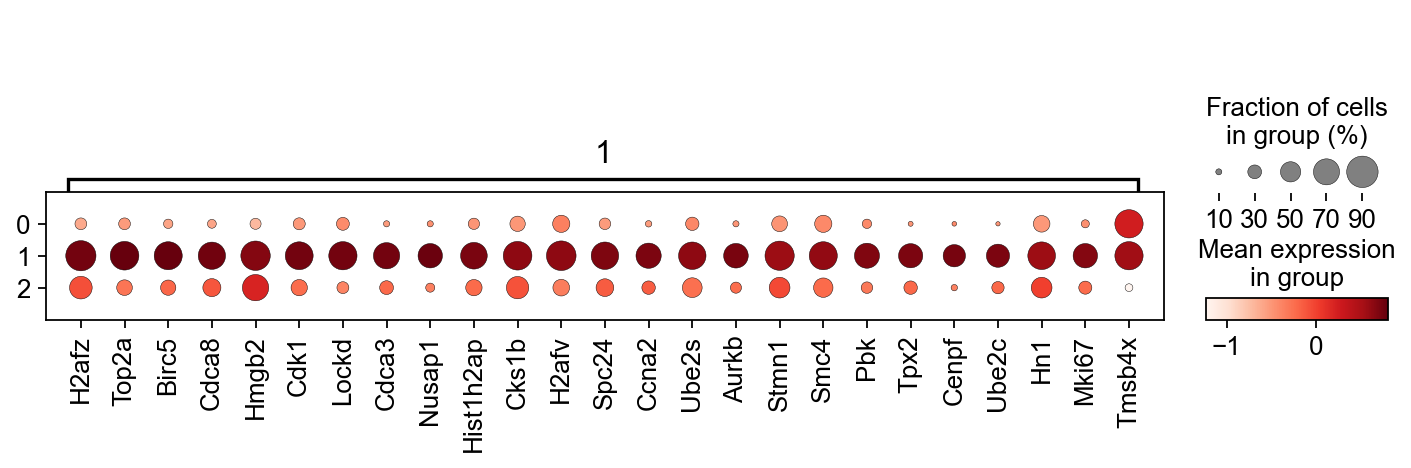

In [1155]:
# closer look at cluster 1
sc.pl.rank_genes_groups_dotplot(adYNorm, n_genes=25, groupby='leiden', groups=["1"],use_raw=False, dendrogram=False)

In [1156]:
adYNorm.obs['leiden']

AAACGGGAGCTGCAAG-1    1
AAACGGGCAGTAAGCG-1    1
AAACGGGGTCCTAGCG-1    1
AAACGGGTCTTGTTTG-1    0
AAAGTAGGTCAGAATA-1    2
                     ..
TTGCGTCGTCAAACTC-1    1
TTGGAACAGGAATCGC-1    0
TTGGAACTCTTTACGT-1    2
TTGTAGGTCTGTCTAT-1    2
TTTGCGCCAGATAATG-1    1
Name: leiden, Length: 386, dtype: category
Categories (3, object): ['0', '1', '2']

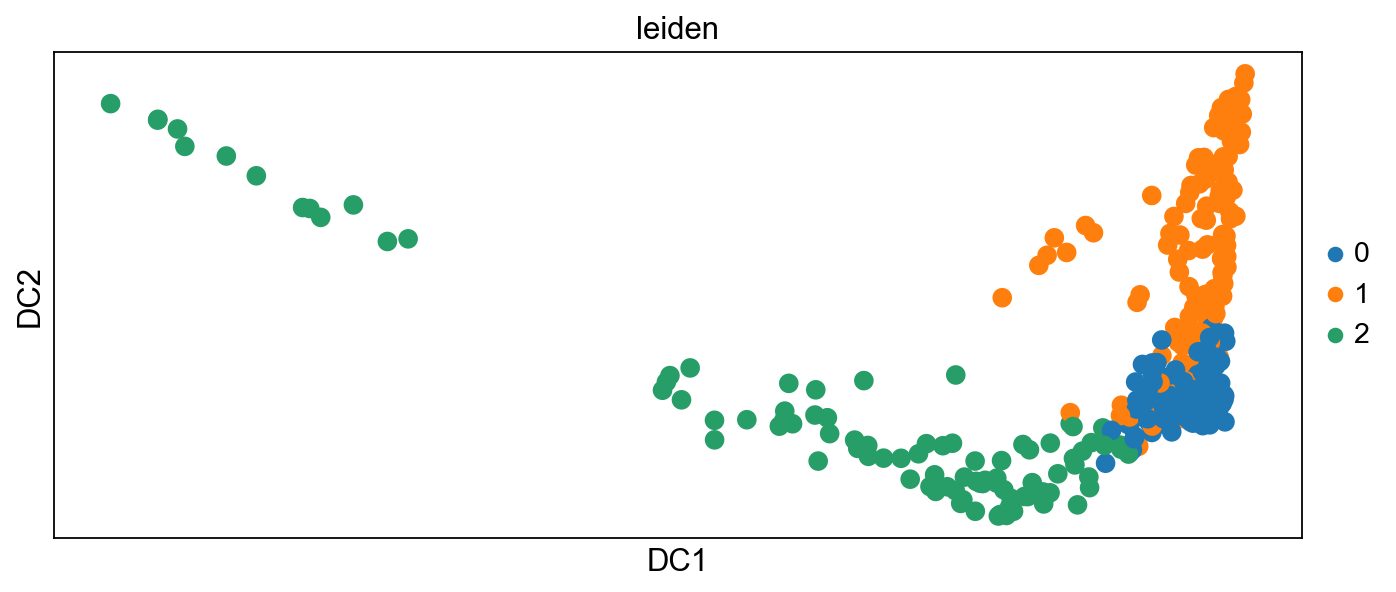

In [1157]:
# compute the diff map
sc.tl.diffmap(adYNorm)
sc.pl.diffmap(adYNorm, color="leiden")

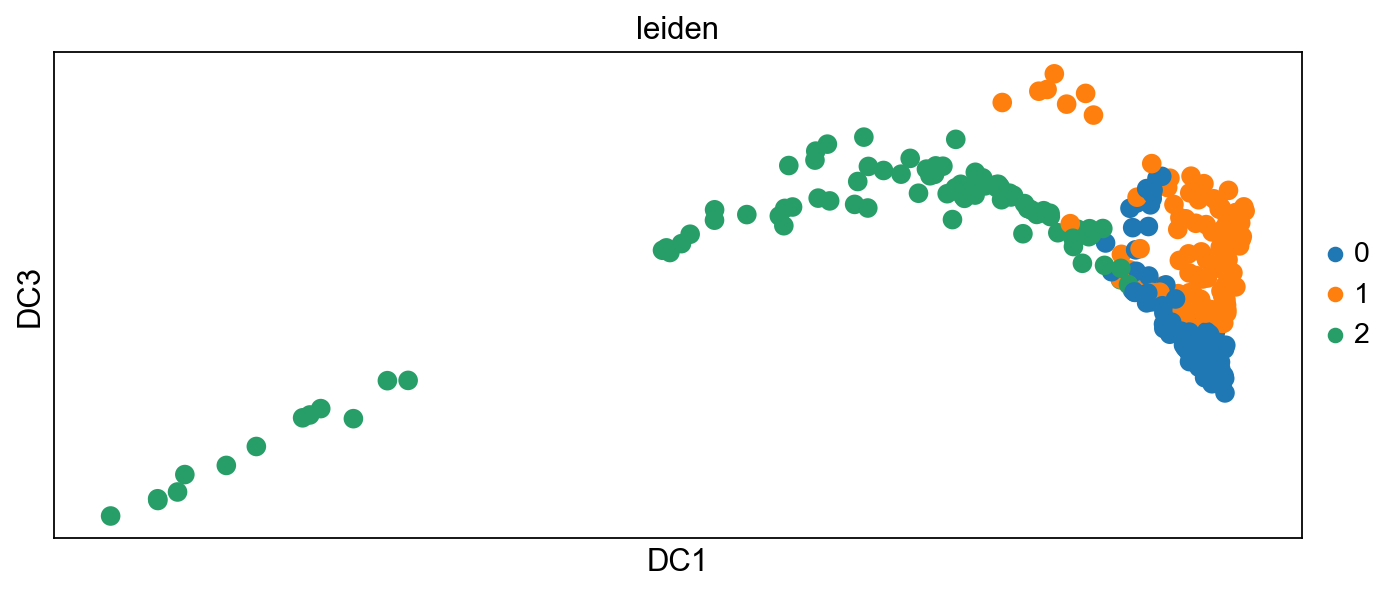

In [1158]:
sc.pl.diffmap(adYNorm, color="leiden", components=["1,3"])

In [1159]:
# classify root, 0 aka blue looks like the root since in the first diff map plot, 2 branches extend off of it
adYNorm.uns['iroot'] = np.flatnonzero(adYNorm.obs['leiden']  == '0')[0]

In [1160]:
# compute pseudotime
sc.tl.dpt(adYNorm, n_branchings=1)

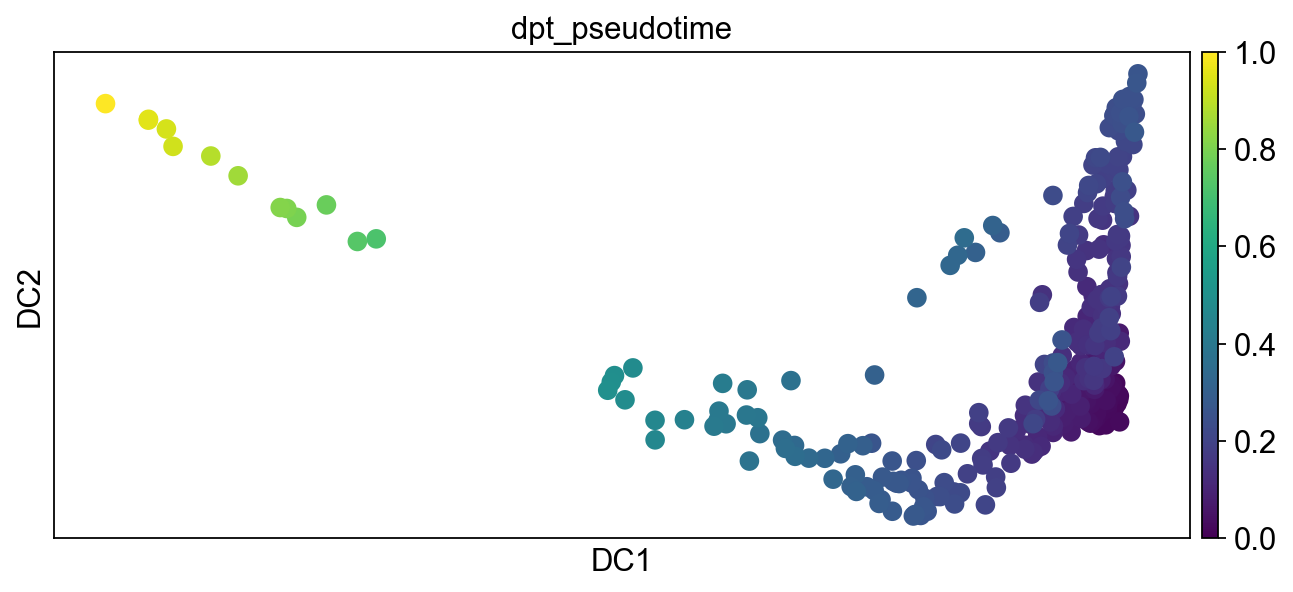

In [1161]:
# diff map colored by pseudotime
sc.pl.diffmap(adYNorm, color="dpt_pseudotime", components=("1,2"), legend_loc='on data')

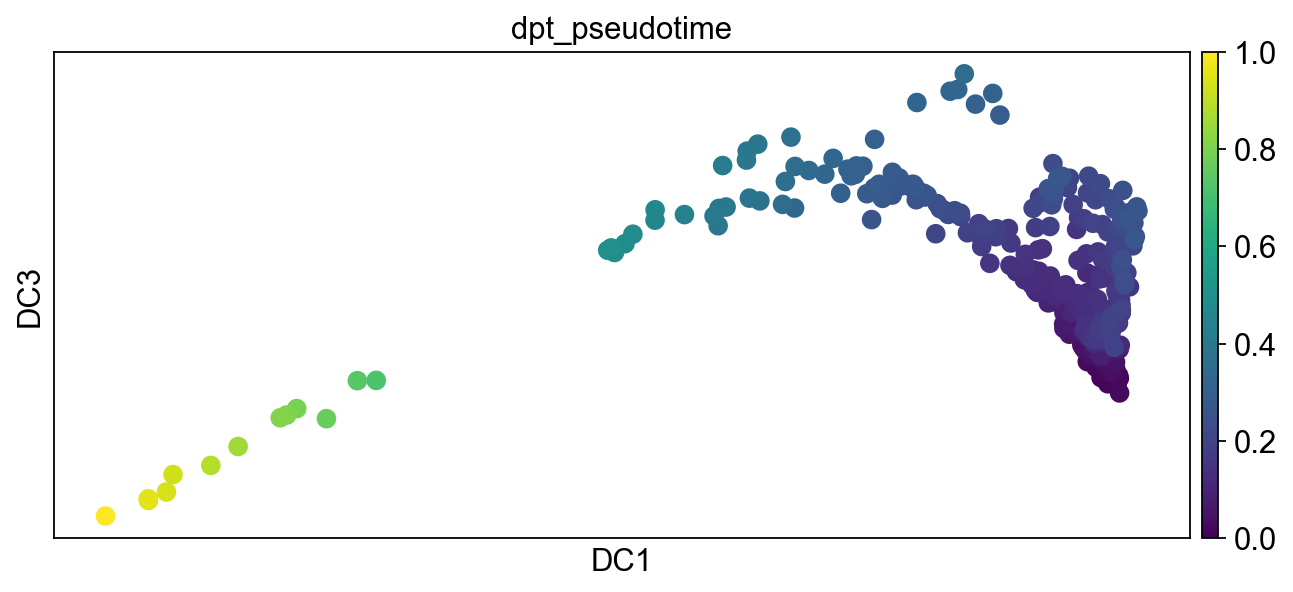

In [1162]:
sc.pl.diffmap(adYNorm, color="dpt_pseudotime", components=("1,3"), legend_loc='on data')

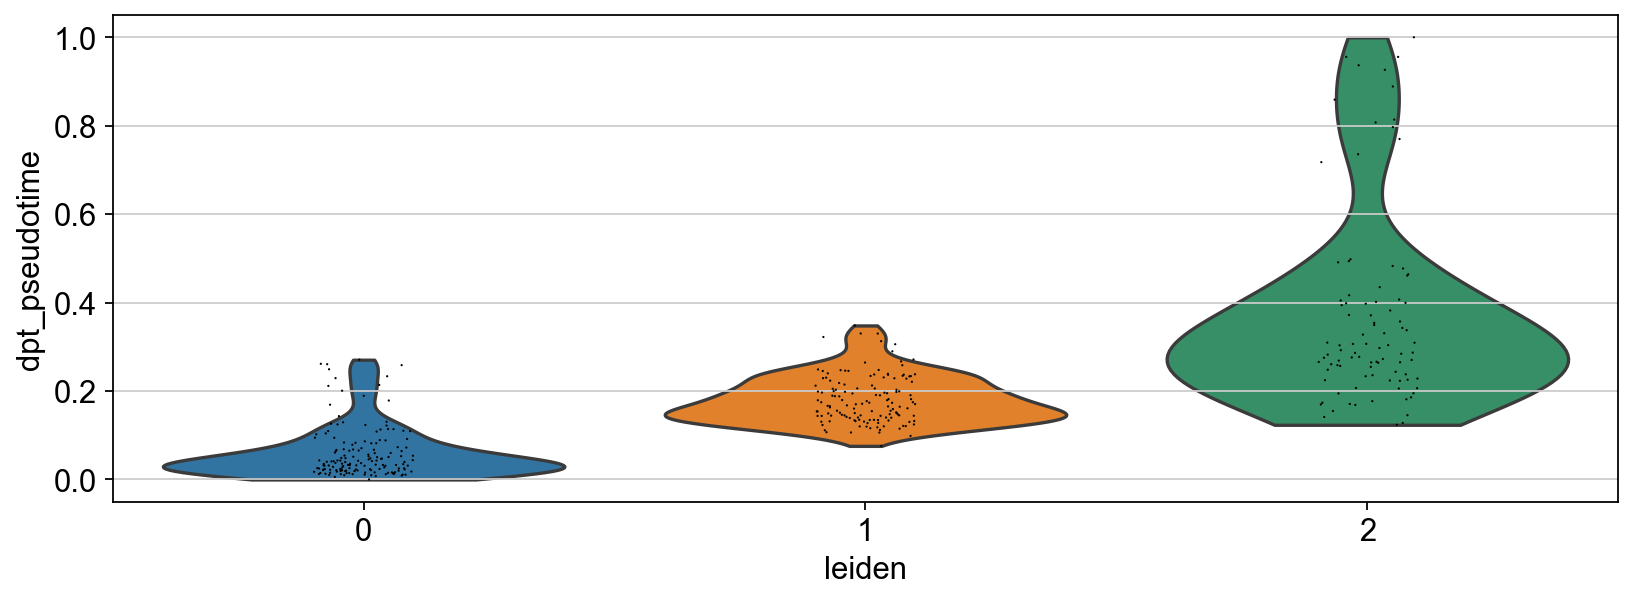

In [1163]:
# violin plot of pseudotime distribution between clusters
sc.pl.violin(adYNorm, "dpt_pseudotime", groupby="leiden")

In [1164]:
adYNorm.obs['leiden'].cat.categories

Index(['0', '1', '2'], dtype='object')

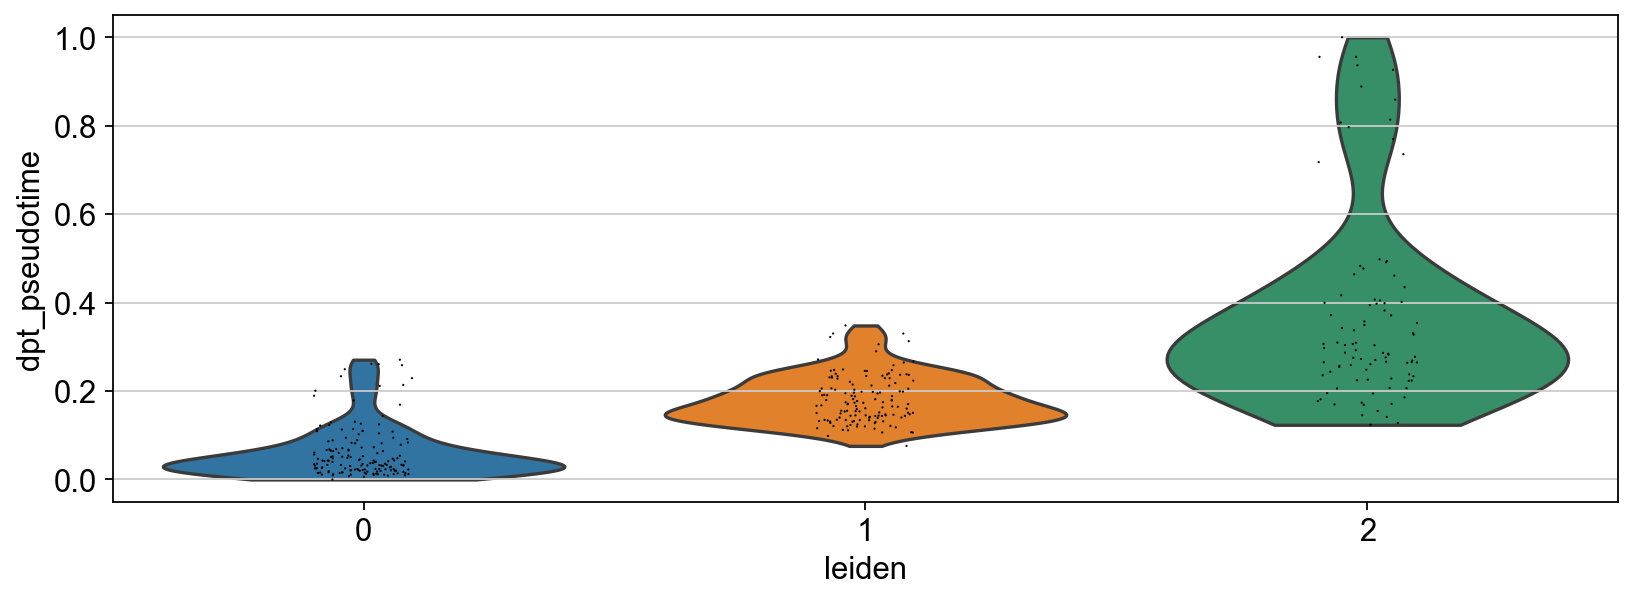

In [1165]:
# reorder the violin plot, this time we didn't need to but sometimes we do
vorder = adYNorm.obs['leiden'].cat.categories[[0,1,2]]
sc.pl.violin(adYNorm, "dpt_pseudotime", groupby="leiden", order=vorder)

<AxesSubplot:title={'center':'dpt_pseudotime'}, xlabel='PC1', ylabel='PC3'>

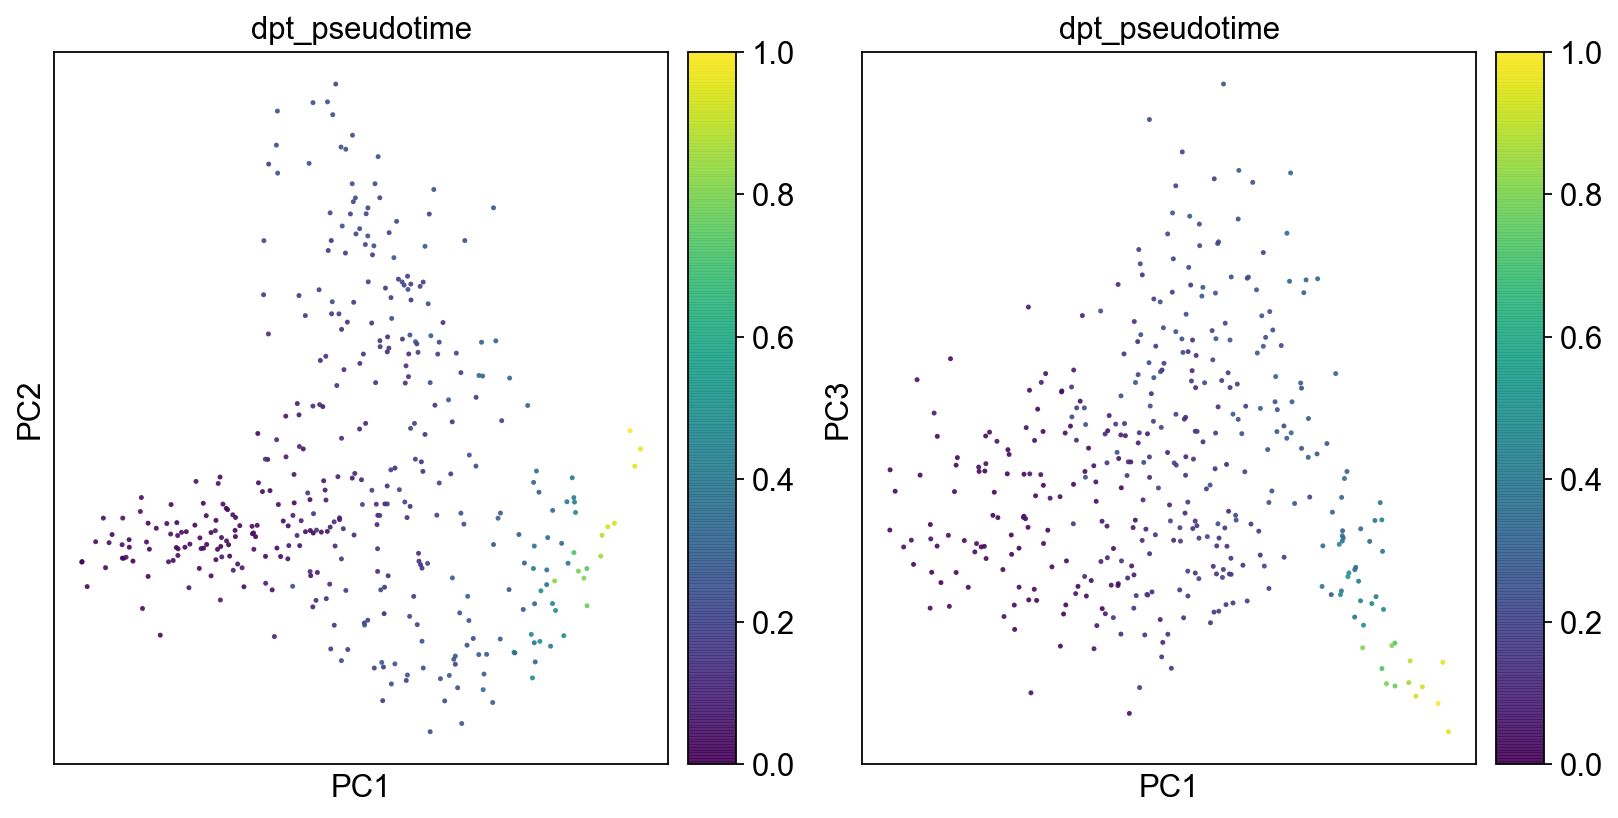

In [1166]:
# replot pca colored by psuedotime
fig, axs = plt.subplots(1,2, figsize=(10,5), constrained_layout=True)
sc.pl.pca(adYNorm, color=["dpt_pseudotime"], alpha=.9, s=20, components="1,2",legend_loc='on data', ax=axs[0], show=False)
sc.pl.pca(adYNorm, color=["dpt_pseudotime"], alpha=.9, s=20, components="1,3",legend_loc='on data', ax=axs[1], show=False)

## Repeat with old HSC's

In [243]:
# this is repeat of above, I just saw the email to wrap repeating code in function and will do that in that future hw's
# filter for only the 2 cell types MPP2 and EryPr
adOld_filt = adOld[(adQOld.obs['SCN_class'] == 'MPP2') | (adQOld.obs['SCN_class'] == 'EryPr')]
adOld_filt.obs # only cells with predicted type MPP2 and EryPr

age sample              cellid  n_genes_by_counts  \
AAACCTGGTCCGAGTC-1  old  old_A  AAACCTGGTCCGAGTC-1               1774   
AAAGCAAAGGAGTACC-1  old  old_A  AAAGCAAAGGAGTACC-1               3616   
AAAGCAACATTAGGCT-1  old  old_A  AAAGCAACATTAGGCT-1               3581   
AAAGCAAGTCCGAGTC-1  old  old_A  AAAGCAAGTCCGAGTC-1               2520   
AAAGCAATCGCAAGCC-1  old  old_A  AAAGCAATCGCAAGCC-1               3299   
...                 ...    ...                 ...                ...   
TTTGCGCGTGTAATGA-1  old  old_A  TTTGCGCGTGTAATGA-1               1985   
TTTGCGCGTTTGGGCC-1  old  old_A  TTTGCGCGTTTGGGCC-1               3479   
TTTGGTTGTACGAAAT-1  old  old_A  TTTGGTTGTACGAAAT-1               1943   
TTTGGTTGTTACGCGC-1  old  old_A  TTTGGTTGTTACGCGC-1               4530   
TTTGTCAGTATAGTAG-1  old  old_A  TTTGTCAGTATAGTAG-1               1801   

                    total_counts  
AAACCTGGTCCGAGTC-1        3765.0  
AAAGCAAAGGAGTACC-1       11348.0  
AAAGCAACATTAGGCT-1       10741.0  
AAAGCAAGTCCGAGTC-1        8516.0  
AAAGCAATCGCAAGCC-1        9745.0  
...                          ...  
TTTGCGCGTGTAATGA-1        4815.0  
TTTGCGCGTTTGGGCC-1       10411.0  
TTTGGTTGTACGAAAT-1        4387.0  
TTTGGTTGTTACGCGC-1       16464.0  
TTTGTCAGTATAGTAG-1        4026.0  

[672 rows x 5 columns]

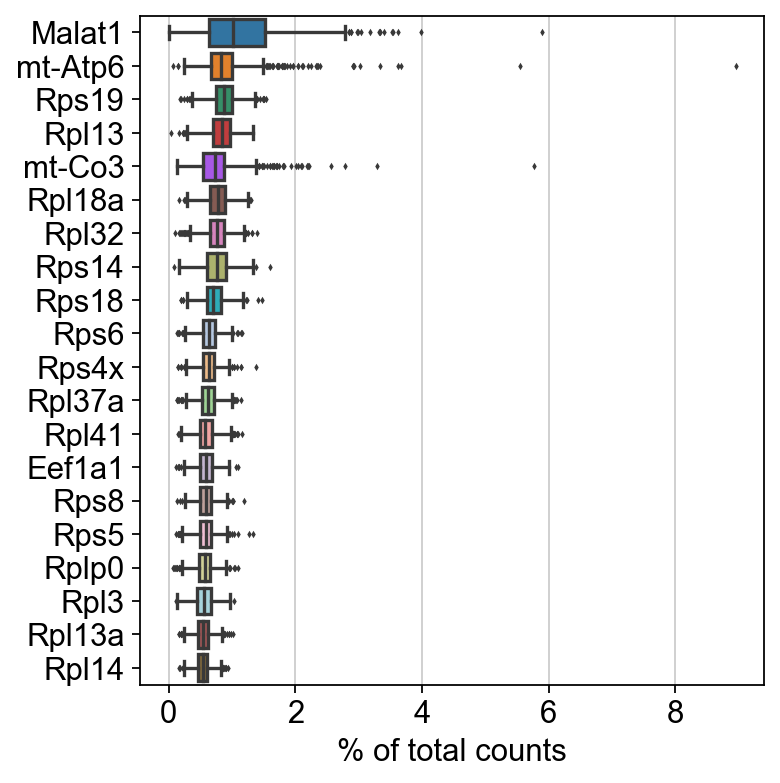

In [244]:
# let's see what the highest expression is like
sc.pl.highest_expr_genes(adOld_filt, n_top=20, )

In [245]:
# preprocessing view ribo and mt expression
adOld_filt.var['mt']= adOld_filt.var_names.str.startswith(("mt-"))
adOld_filt.var['ribo'] = adOld_filt.var_names.str.startswith(("Rps","Rpl"))
sc.pp.calculate_qc_metrics(adOld_filt, qc_vars=['ribo', 'mt'], percent_top=None, log1p=False, inplace=True)

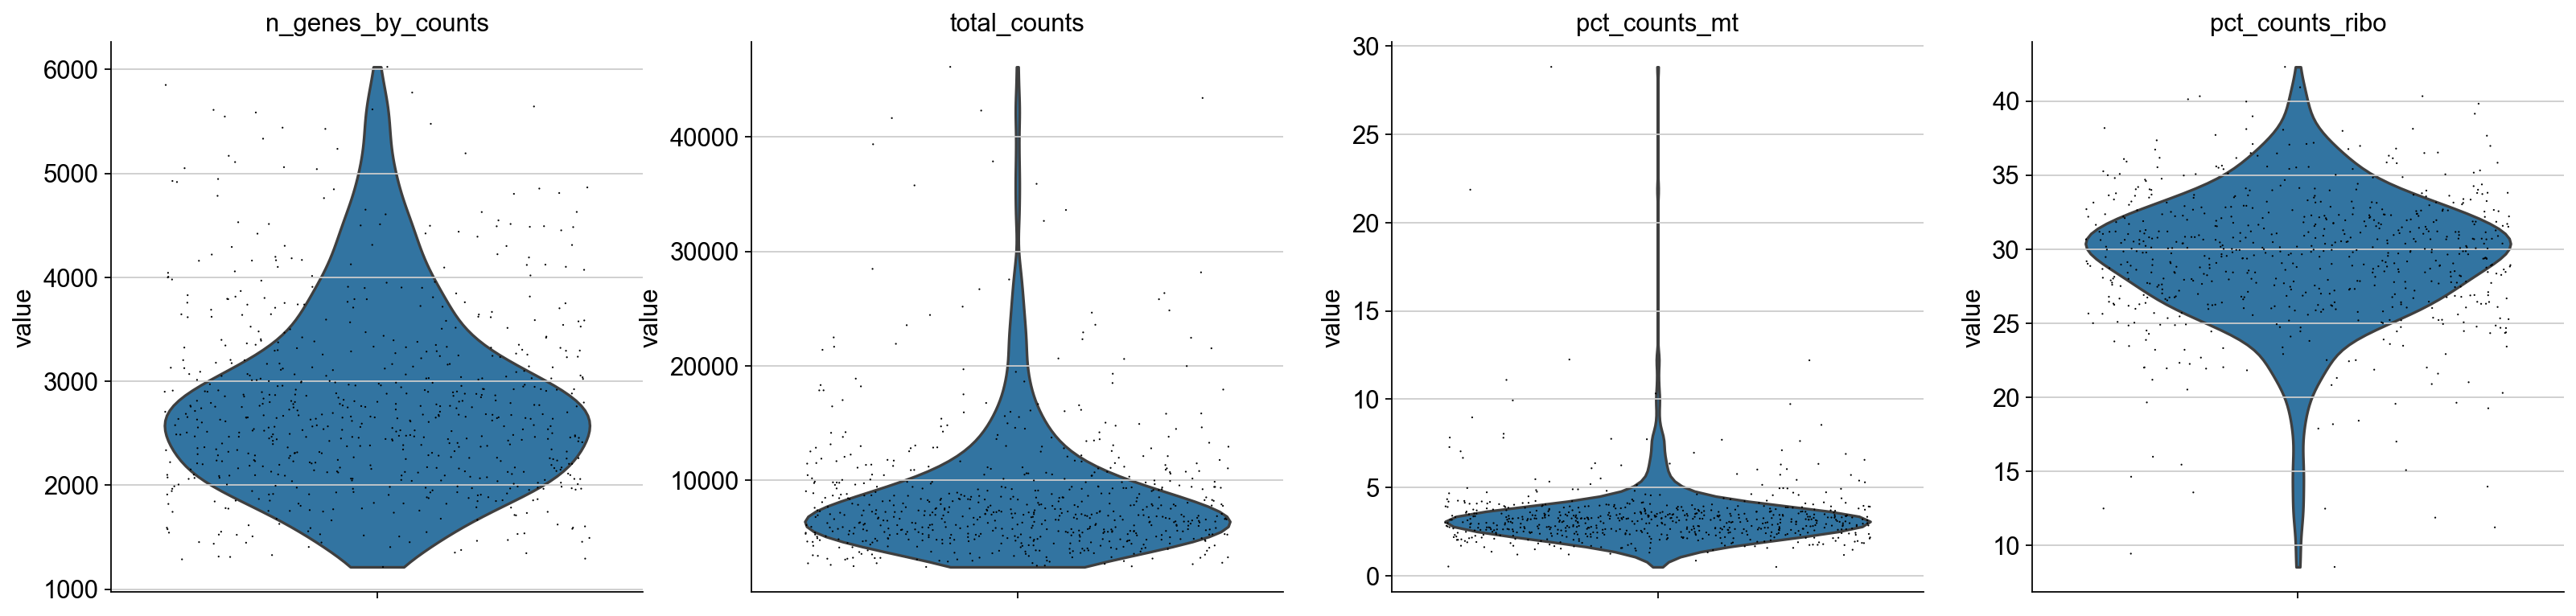

In [246]:
# view ribo, mt %
axs = sc.pl.violin(adOld_filt, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'pct_counts_ribo'],jitter=0.4, multi_panel=True)

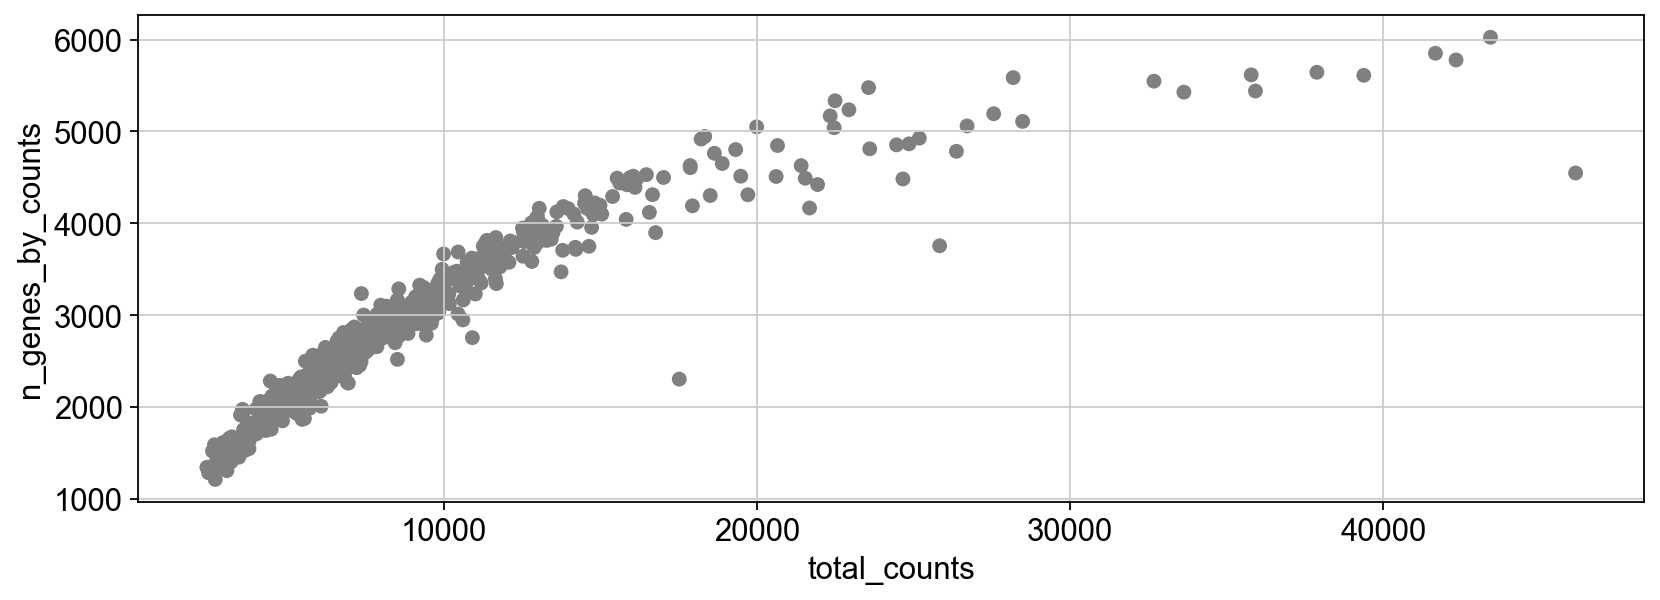

In [247]:
# total counts vs n genes by counts
sc.pl.scatter(adOld_filt, x='total_counts', y='n_genes_by_counts')

In [248]:
# only mt and total count look like they have some value that are too high so lets remove them
# like before, try to remove excess tip
adOld_filt = adOld_filt[adOld_filt.obs['total_counts'] < 30000, :]
adOld_filt = adOld_filt[adOld_filt.obs['pct_counts_mt'] < 10, :]

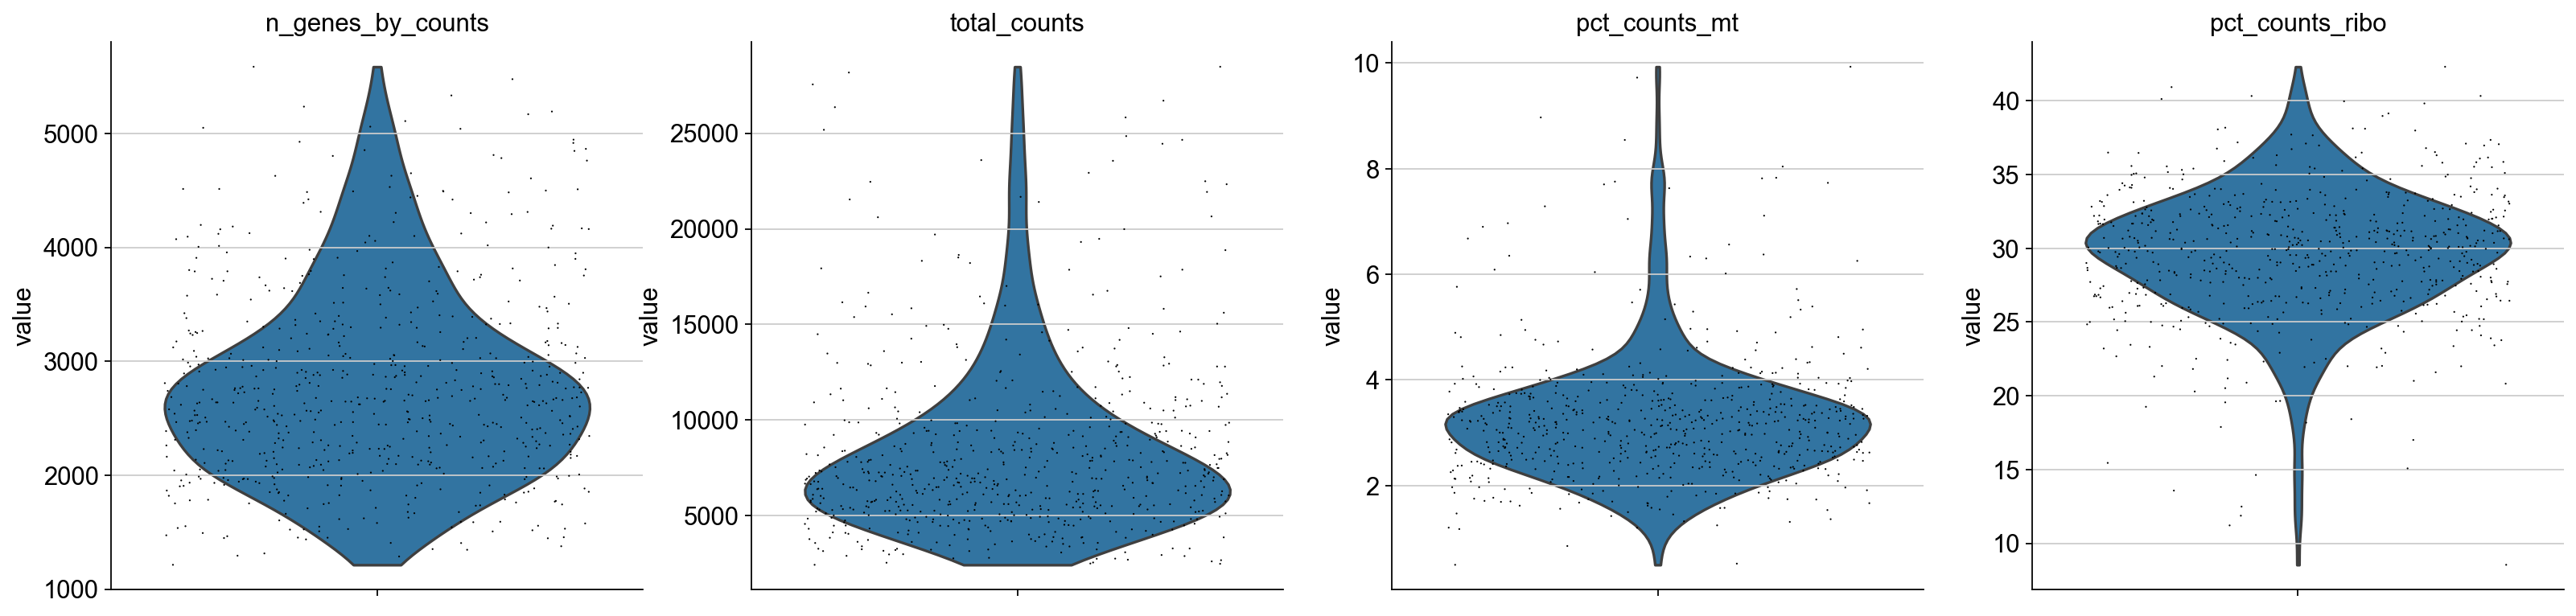

In [249]:
# replot after filtering
axs = sc.pl.violin(adOld_filt, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'pct_counts_ribo'],jitter=0.4, multi_panel=True)

In [250]:
# doublet filtering following 10x chart
print("Number of cells: ",adOld_filt.n_obs)

# figure out the total counts == 98 percentile
thresh = np.percentile(adOld_filt.obs['total_counts'],98) # 98% since we have 2500 total cells recovered
print("98th percentile: ",thresh)

adOld_filt = adOld_filt[adOld_filt.obs['total_counts'] < thresh, :]
print("Number of cells: ",adOld_filt.n_obs)

Number of cells:  656
98th percentile:  22486.999999999996
Number of cells:  642


In [251]:
# remove bad genes 
mito_genes = adOld_filt.var_names.str.startswith('mt-')
ribo_genes = adOld_filt.var_names.str.startswith(("Rpl","Rps"))
malat_gene = adOld_filt.var_names.str.startswith("Malat1")

remove = np.add(mito_genes, ribo_genes)
remove = np.add(remove, malat_gene)
keep = np.invert(remove)

print('# of genes to remove:', len(keep) - np.count_nonzero(keep))

adOld_filt = adOld_filt[:,keep].copy()
print("Number of genes: ",  adOld_filt.n_vars)

# of genes to remove: 127
Number of genes:  28565


In [252]:
adONorm = adOld_filt.copy()
# filter for genes that are in atleast 5 cells
sc.pp.filter_genes(adONorm, min_cells=5)

# normalize
sc.pp.normalize_per_cell(adONorm, counts_per_cell_after=1e4)

# log transform 
sc.pp.log1p(adONorm)

# ID HVG's
sc.pp.highly_variable_genes(adONorm, min_mean=0.0125, max_mean=5, min_disp=0.25)

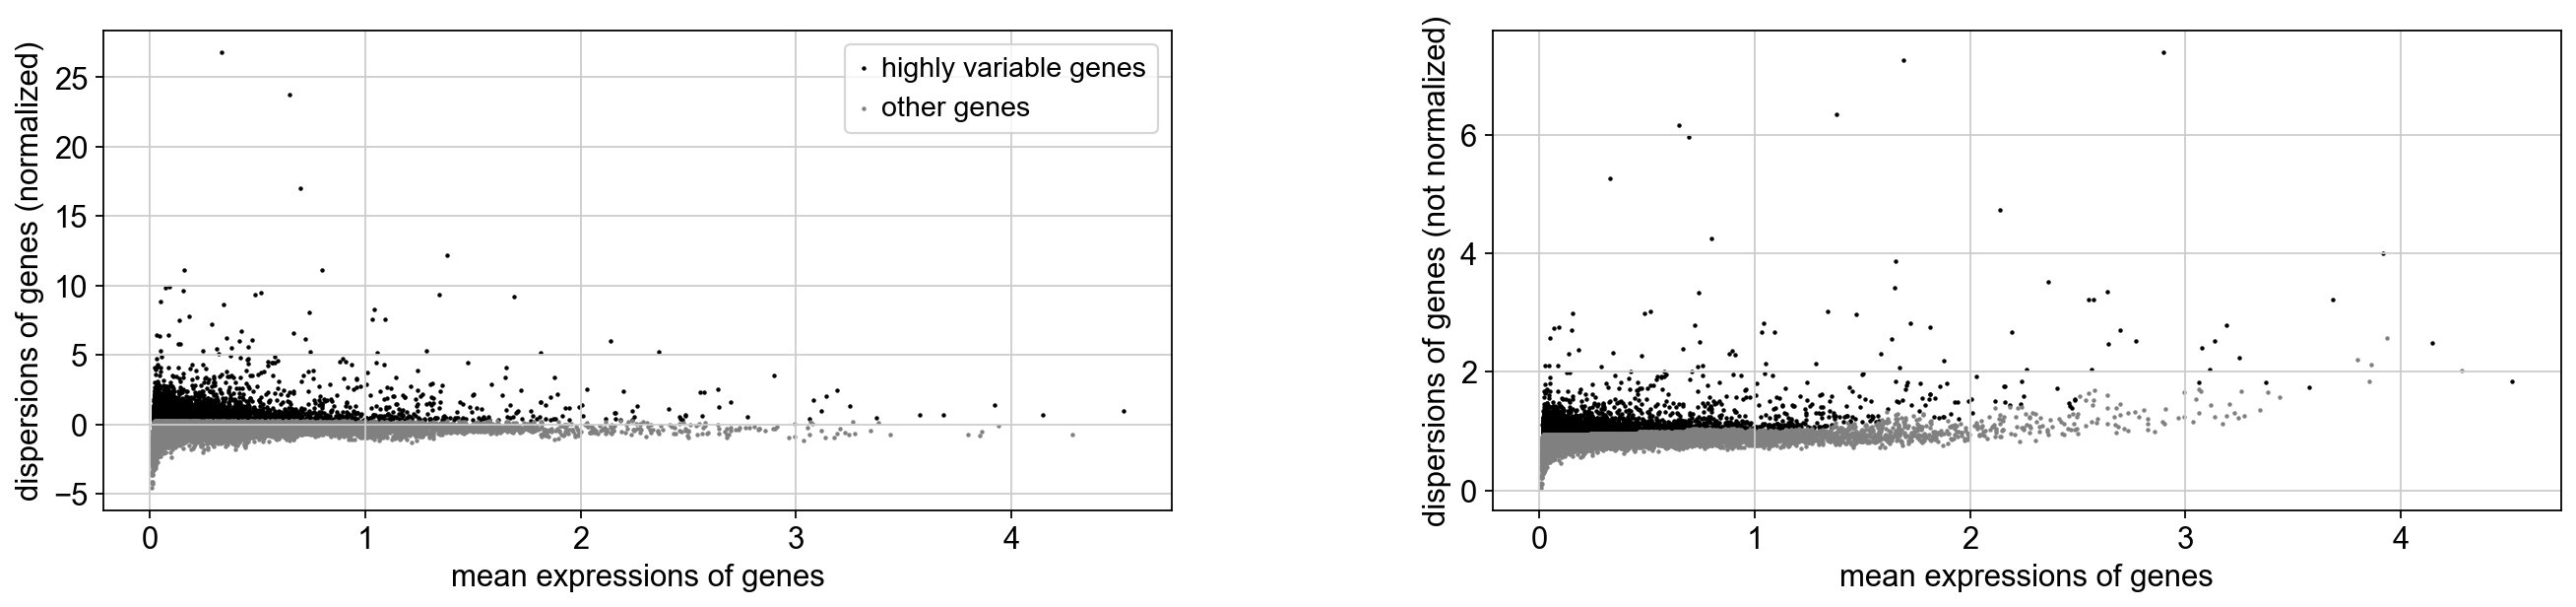

In [253]:
sc.pl.highly_variable_genes(adONorm)

In [254]:
adONorm.raw = adONorm
# scale
sc.pp.scale(adONorm, max_value=10)

# compute pca
sc.tl.pca(adONorm, n_comps=100)

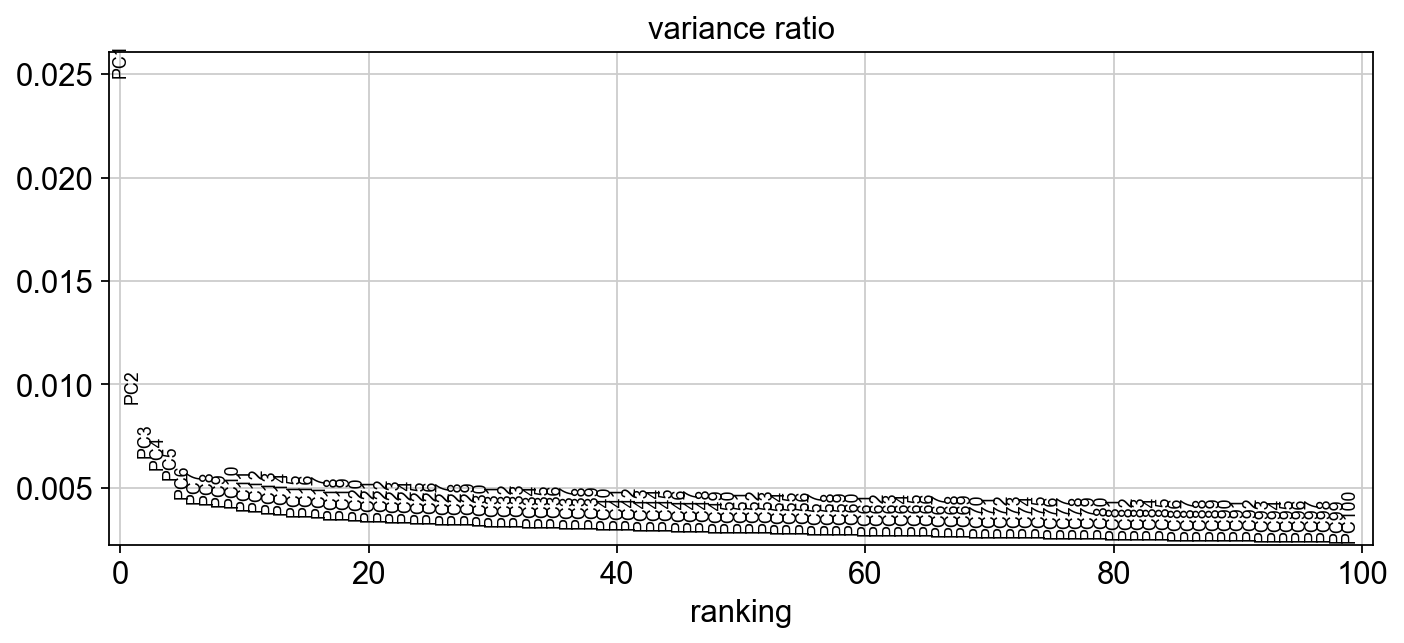

In [255]:
# plot signif of each pc
sc.set_figure_params(figsize="10, 4")
sc.pl.pca_variance_ratio(adONorm, 100)

In [293]:
# clustering
npcs = 40
nknns = 9
sc.pp.neighbors(adONorm, n_neighbors=nknns, n_pcs=npcs)
sc.tl.leiden(adONorm,.25)

<AxesSubplot:title={'center':'leiden'}, xlabel='PC1', ylabel='PC3'>

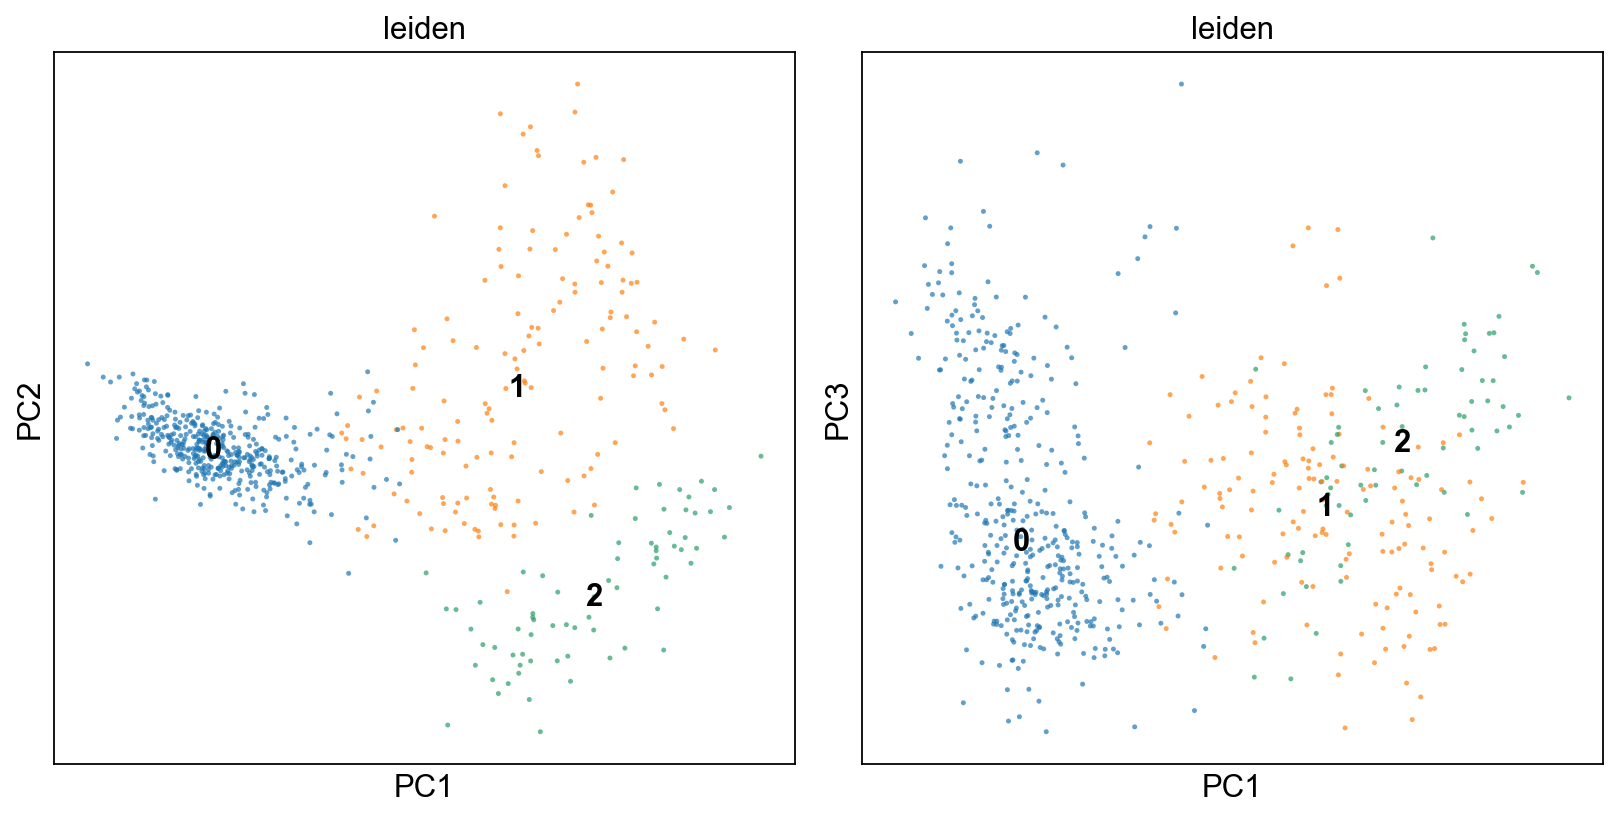

In [294]:
# plot pca's colored by leiden, we can see 3 clusterse again
fig, axs = plt.subplots(1,2, figsize=(10,5), constrained_layout=True)
sc.pl.pca(adONorm, color=["leiden"], alpha=.7, s=20, components="1,2",legend_loc='on data', ax=axs[0], show=False)
sc.pl.pca(adONorm, color=["leiden"], alpha=.7, s=20, components="1,3",legend_loc='on data', ax=axs[1], show=False)

In [319]:
# rank genes in each group
sc.tl.rank_genes_groups(adONorm, 'leiden', use_raw=False)

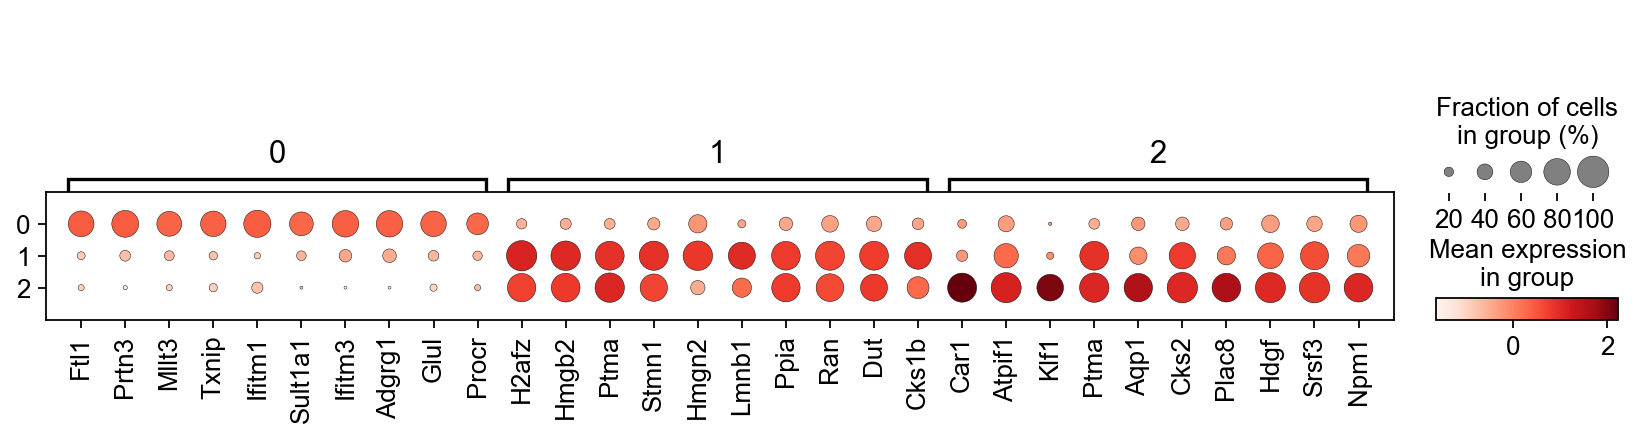

In [320]:
# plot n genes differentially expressed between clusters
sc.pl.rank_genes_groups_dotplot(adONorm, n_genes=10, groupby='leiden', use_raw=False, dendrogram=False)

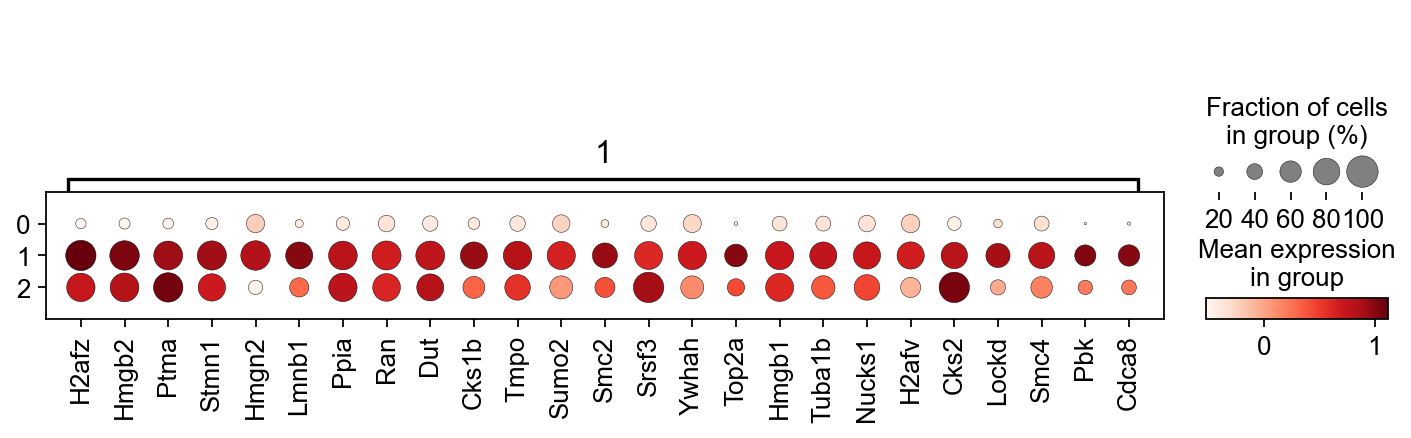

In [321]:
# close up of cluster 1
sc.pl.rank_genes_groups_dotplot(adONorm, n_genes=25, groupby='leiden', groups=["1"],use_raw=False, dendrogram=False)

In [299]:
adONorm.obs['leiden']

AAACCTGGTCCGAGTC-1    1
AAAGCAAAGGAGTACC-1    0
AAAGCAACATTAGGCT-1    1
AAAGCAAGTCCGAGTC-1    2
AAAGCAATCGCAAGCC-1    1
                     ..
TTTGCGCGTGTAATGA-1    0
TTTGCGCGTTTGGGCC-1    1
TTTGGTTGTACGAAAT-1    0
TTTGGTTGTTACGCGC-1    0
TTTGTCAGTATAGTAG-1    0
Name: leiden, Length: 642, dtype: category
Categories (3, object): ['0', '1', '2']

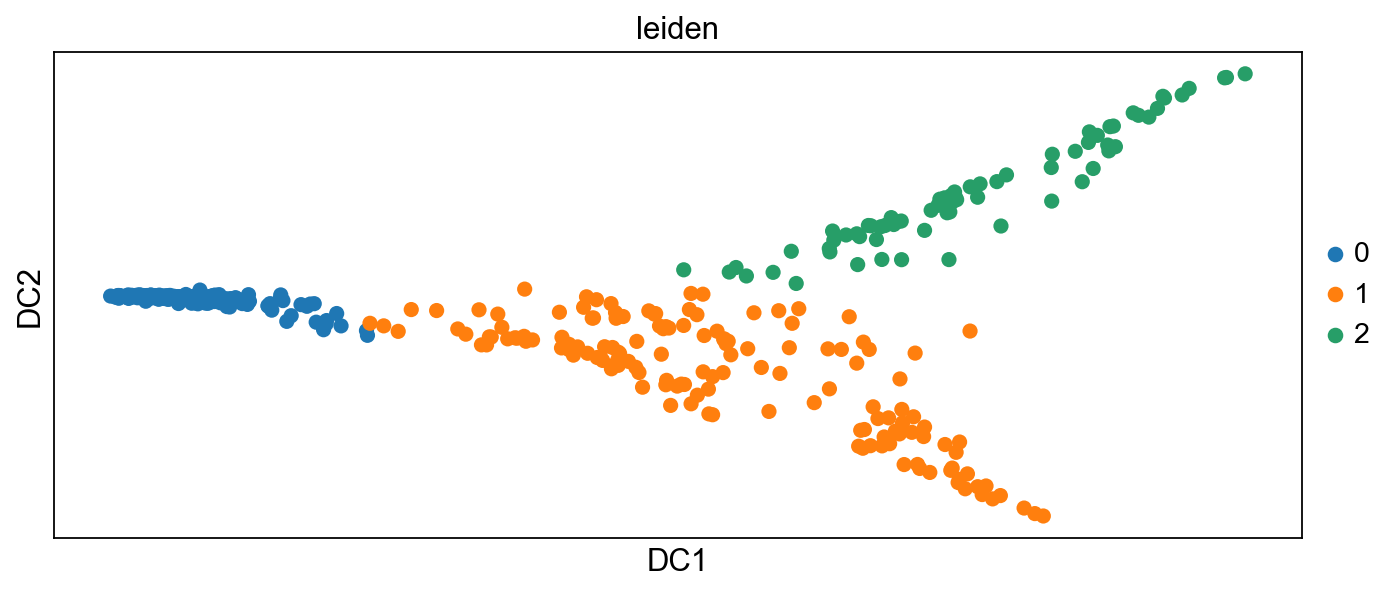

In [300]:
# compute diff map
sc.tl.diffmap(adONorm)
sc.pl.diffmap(adONorm, color="leiden")

# like with young, 0 aka blue looks like the root since two branches come off of it 

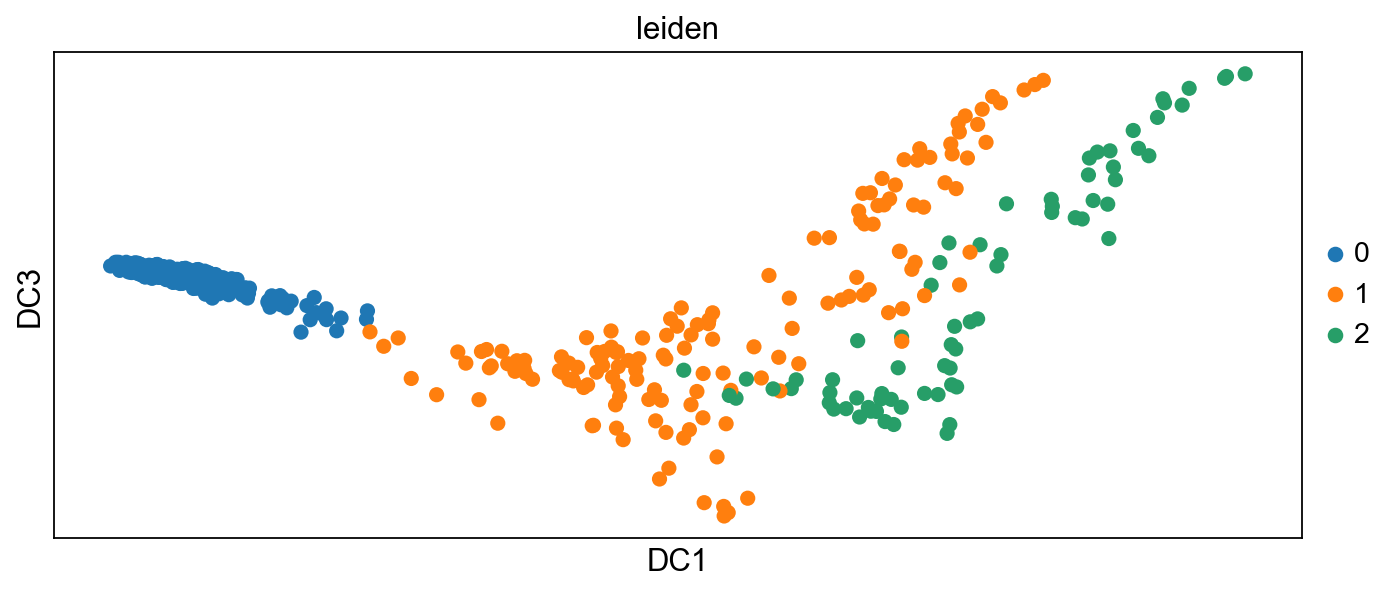

In [301]:
sc.pl.diffmap(adONorm, color="leiden", components=["1,3"])

In [302]:
# classify root
adONorm.uns['iroot'] = np.flatnonzero(adONorm.obs['leiden']  == '0')[0]

In [310]:
# compute pseudotime
sc.tl.dpt(adONorm, n_branchings=1)

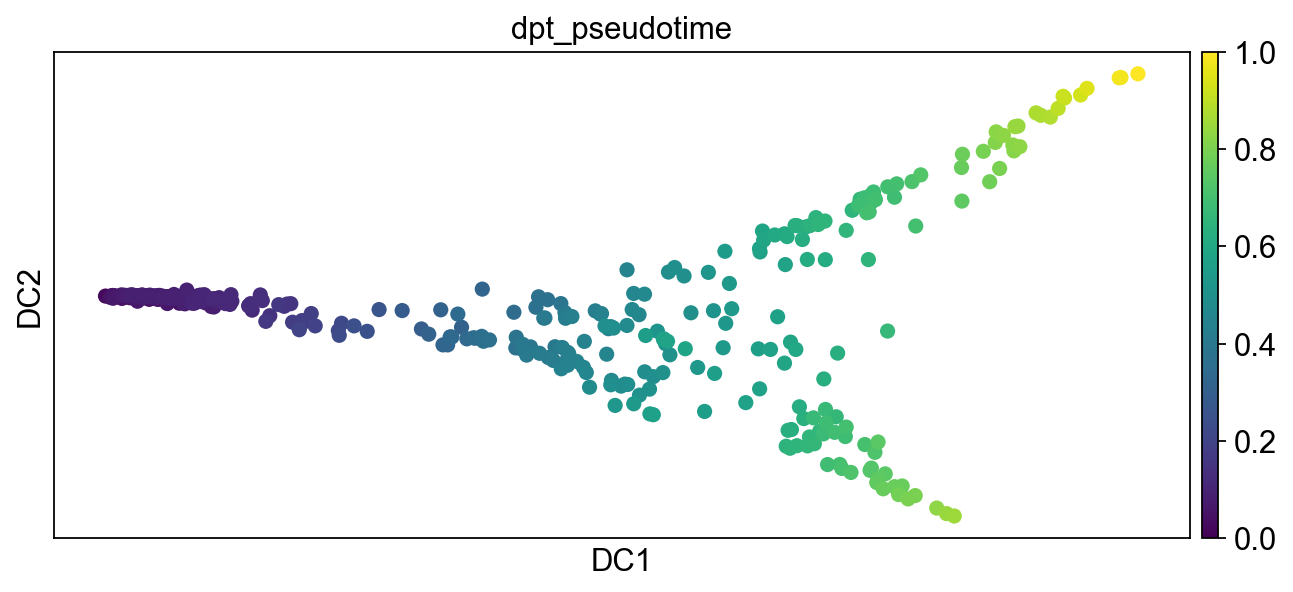

In [311]:
# plot diffmap colored pseudotime
sc.pl.diffmap(adONorm, color="dpt_pseudotime", components=("1,2"), legend_loc='on data')

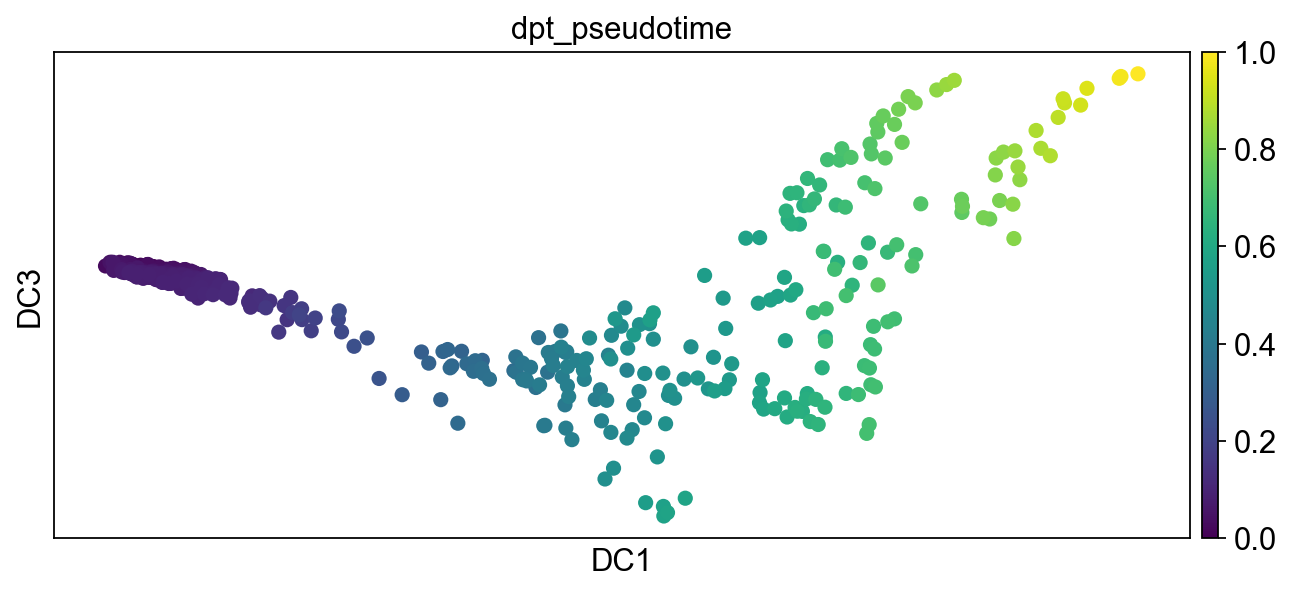

In [312]:
sc.pl.diffmap(adONorm, color="dpt_pseudotime", components=("1,3"), legend_loc='on data')

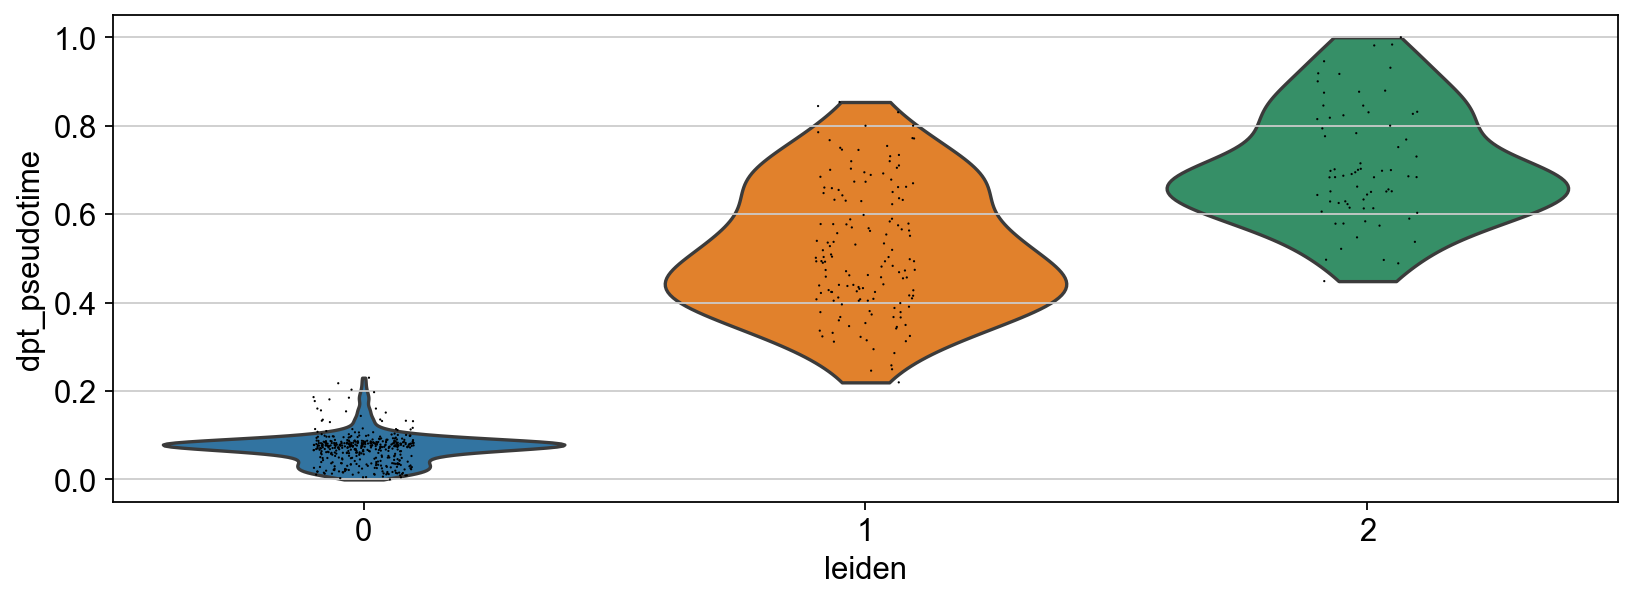

In [313]:
# violin plot of pseudotimes by cluster
sc.pl.violin(adONorm, "dpt_pseudotime", groupby="leiden")

In [314]:
adONorm.obs['leiden'].cat.categories

Index(['0', '1', '2'], dtype='object')

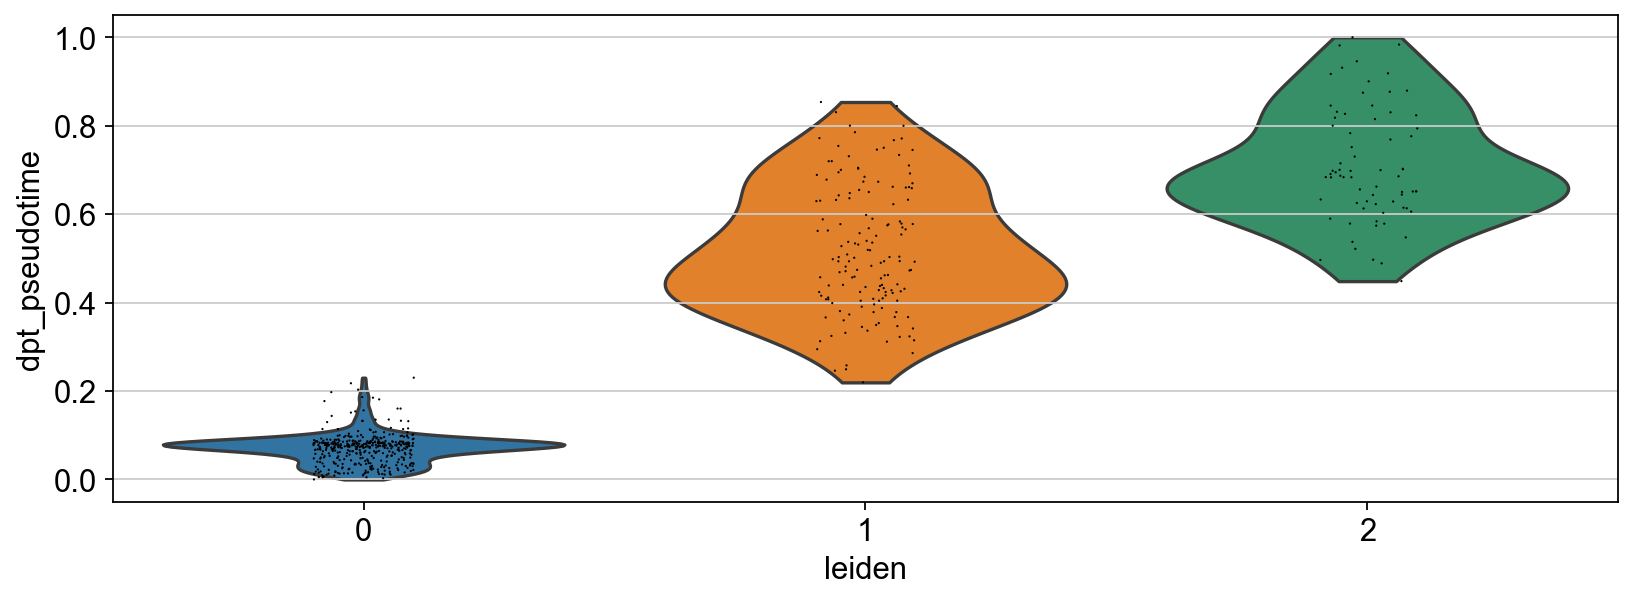

In [315]:
# reorg the violin, like before we don't need to do it here but sometimes we do
vorder = adONorm.obs['leiden'].cat.categories[[0,1,2]]
sc.pl.violin(adONorm, "dpt_pseudotime", groupby="leiden", order=vorder)

<AxesSubplot:title={'center':'dpt_pseudotime'}, xlabel='PC1', ylabel='PC3'>

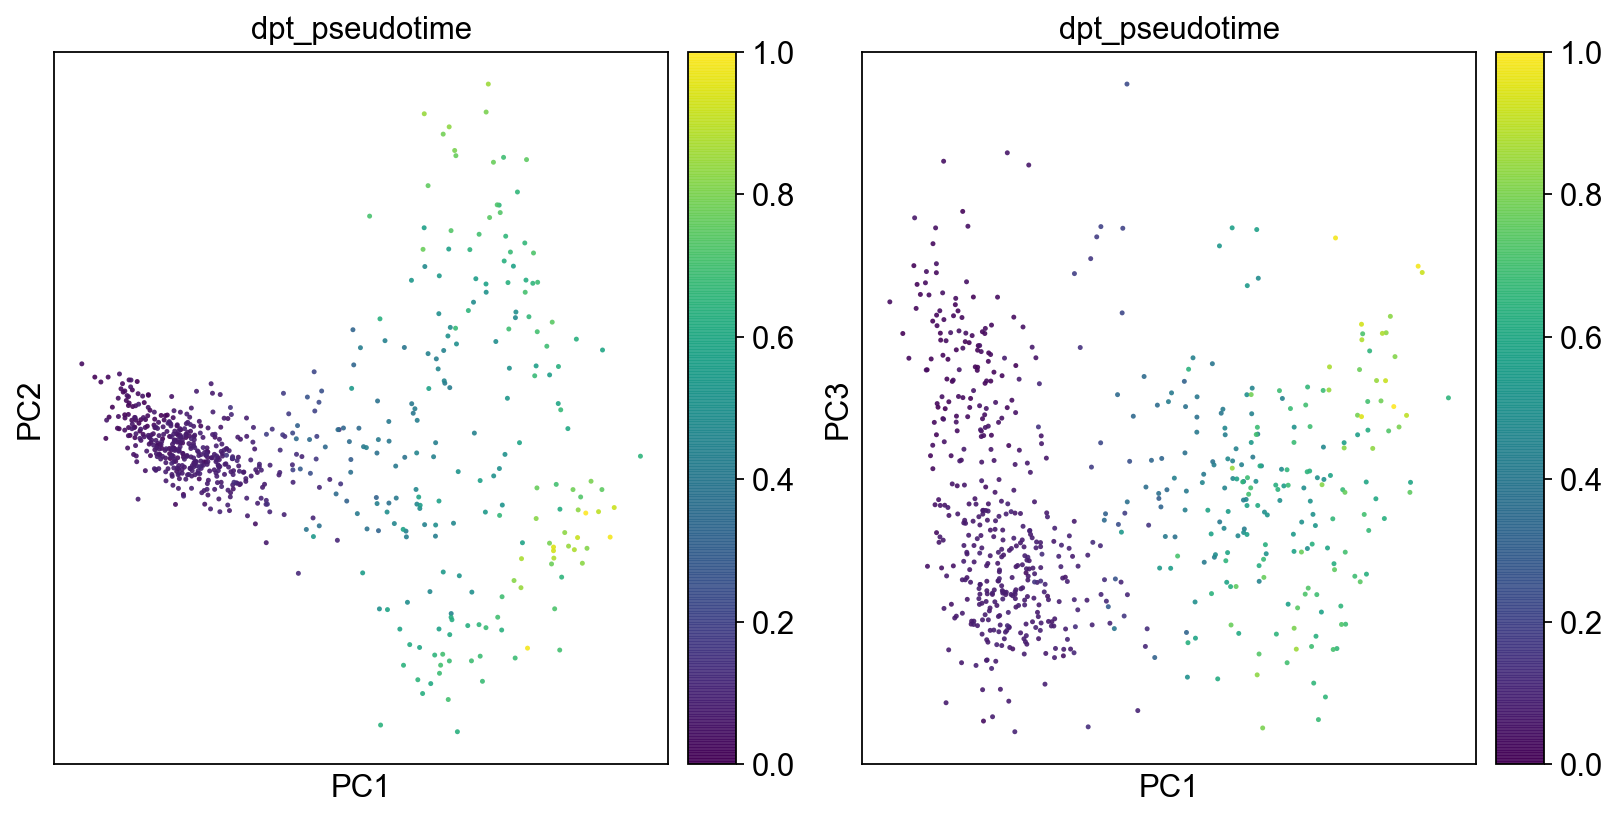

In [316]:
# replot pca's colored by pseudotime
fig, axs = plt.subplots(1,2, figsize=(10,5), constrained_layout=True)
sc.pl.pca(adONorm, color=["dpt_pseudotime"], alpha=.9, s=20, components="1,2",legend_loc='on data', ax=axs[0], show=False)
sc.pl.pca(adONorm, color=["dpt_pseudotime"], alpha=.9, s=20, components="1,3",legend_loc='on data', ax=axs[1], show=False)

### Your mission: Part 3

Interpret your results. What do the branches represent? How do the trajectories differ between samples? 
How might these difference(s) contribute to the lower number of erythroid cells in old mice?
You may explore and support your reasoning by further analysis and visualizations, including clustering, PAGA, differential expression, and cell cycle scoring. 

In [50]:
# Part 3 code, figures and explanatory text goes here and in subsequent cells. Show all code.

In [317]:
# define gene lists for each lineage
hs_genes = ['Procr', 'Mllt3', 'Hlf', 'Fgd5', 'Hoxa9']
meg_genes = ['Pf4', 'Itga2b']
eryth_genes = ['Klf1', 'Gata1', 'Epor']

Start with the young hsc's

In [749]:
adYNorm

AnnData object with n_obs × n_vars = 386 × 11350
    obs: 'age', 'sample', 'cellid', 'n_genes_by_counts', 'total_counts', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_mt', 'pct_counts_mt', 'n_counts', 'leiden', 'dpt_pseudotime', 'dpt_groups', 'dpt_order', 'dpt_order_indices'
    var: 'gene_ids', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'mt', 'ribo', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'leiden', 'leiden_colors', 'rank_genes_groups', 'diffmap_evals', 'iroot', 'dpt_changepoints', 'dpt_grouptips'
    obsm: 'X_pca', 'X_diffmap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

in the next 3 cells we plot dotplots to view differential expression between clusters for our genes of interest 

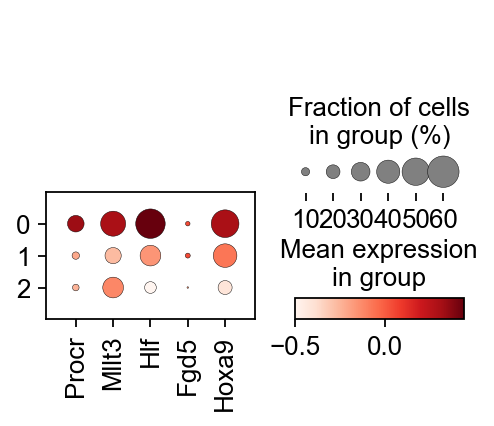

In [1167]:
# expression differences between clusters for HS and progens genes 
sc.pl.rank_genes_groups_dotplot(adYNorm, var_names = hs_genes, groupby='leiden',use_raw=False, dendrogram=False)
# 0 aka blue branch looks like the hsc

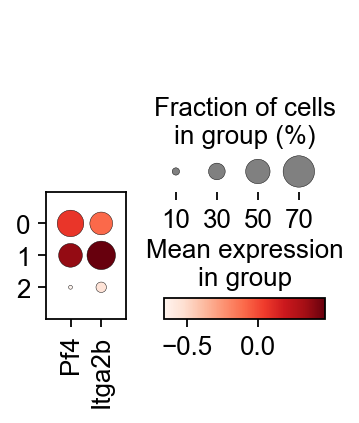

In [1168]:
# expression differences between clusters for meg progens genes 
sc.pl.rank_genes_groups_dotplot(adYNorm, var_names = meg_genes, groupby='leiden',use_raw=False, dendrogram=False)
# 1 aka orange branch looks like meg

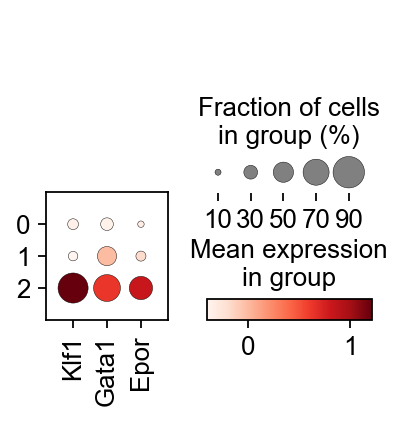

In [1169]:
# expression differences between clusters for eryth progens genes 
sc.pl.rank_genes_groups_dotplot(adYNorm, var_names = eryth_genes, groupby='leiden',use_raw=False, dendrogram=False)
# 2 aka green branch looks like eryth

In [1178]:
# let's rename our leidens to what we think they are
new_sc_names = ['HS', 'Meg', 'Eryth']
adYNorm.rename_categories('leiden', new_sc_names)

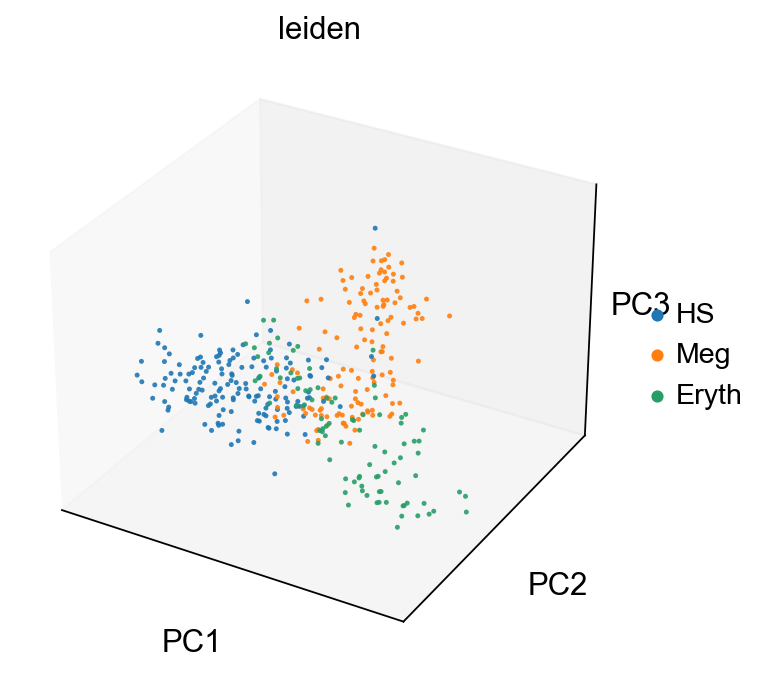

In [1180]:
# 3d pca colored by leiden
sc.pl.pca(adYNorm, color=["leiden"], alpha=.9, s=25, projection='3d')

In [1181]:
# compute paga
sc.tl.paga(adYNorm, groups='leiden')

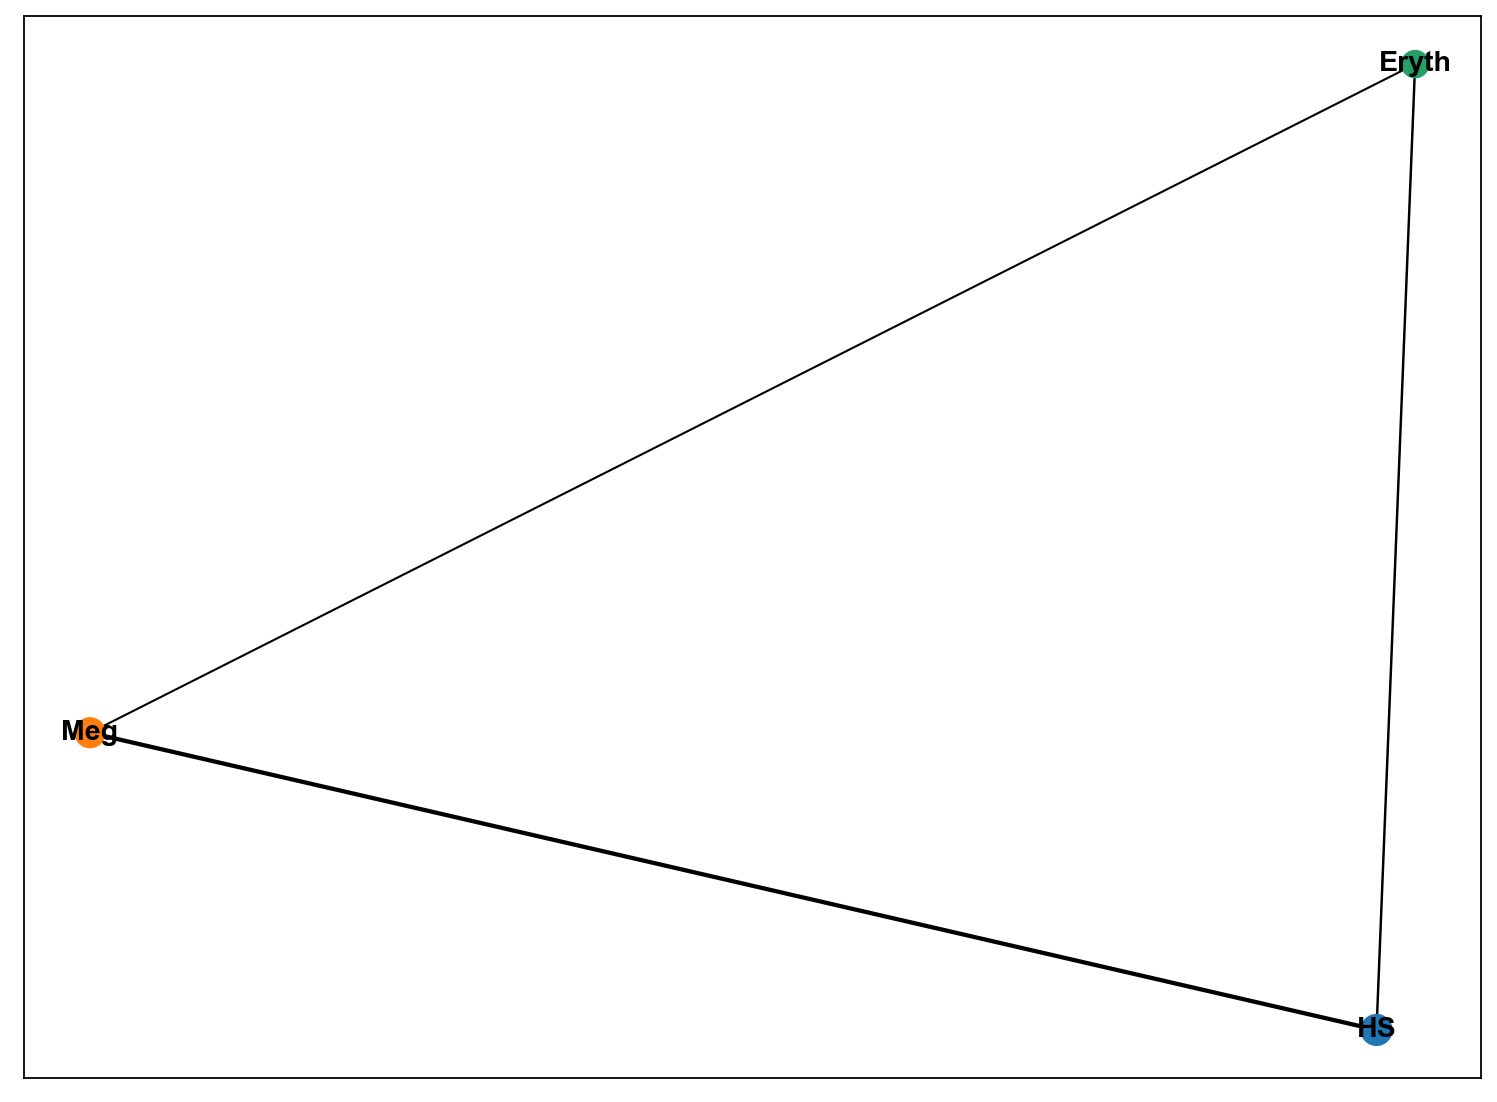

In [1182]:
# plot paga
sc.set_figure_params(figsize="10, 8")
sc.pl.paga(adYNorm, color=['leiden'])

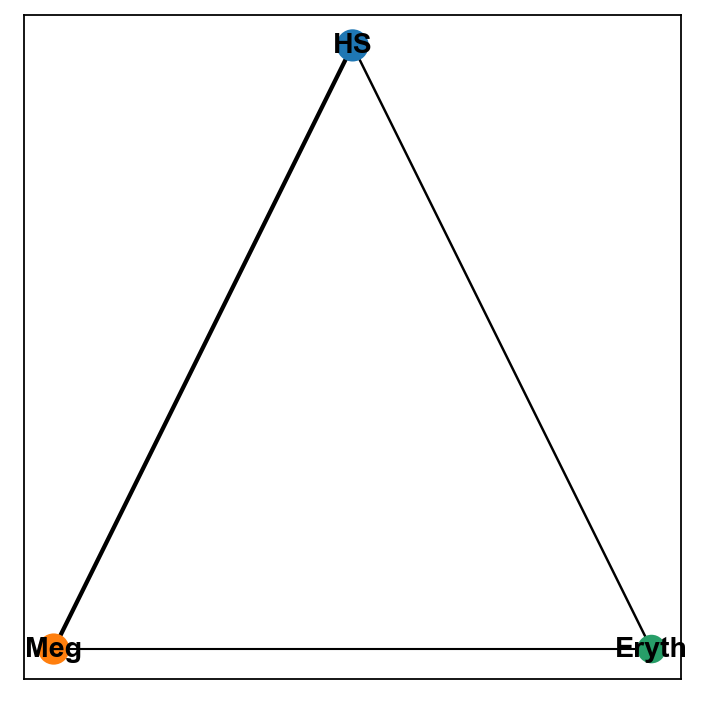

In [1183]:
# plot reoriented paga
sc.set_figure_params(figsize="5, 5")
sc.pl.paga(adYNorm,color=['leiden'], layout="rt", root=0, single_component=True)

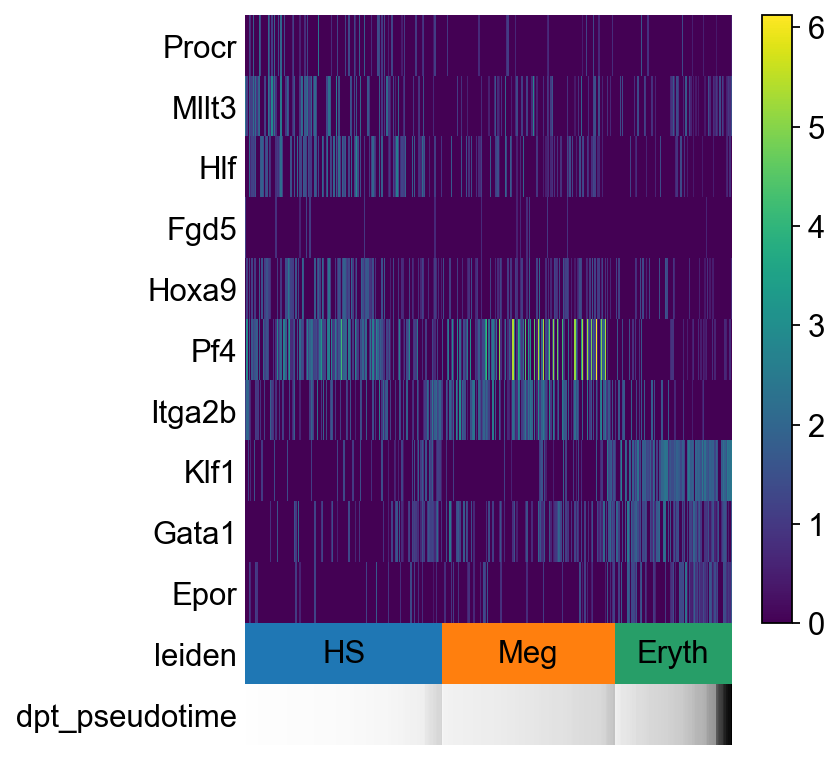

In [1184]:
# plot paga path with the genes of interest 
# we can see the differential expression across groups
sc.pl.paga_path(adYNorm, [0, 1, 2], keys=hs_genes + meg_genes + eryth_genes)

In [1203]:
# score the genes of interest 
sc.tl.score_genes(adYNorm, gene_list = hs_genes, score_name = "hs_genesets", use_raw=False)
sc.tl.score_genes(adYNorm, gene_list = meg_genes, score_name = "meg_genesets", use_raw=False)
sc.tl.score_genes(adYNorm, gene_list = eryth_genes, score_name = "eryth_genesets", use_raw=False)

In [1204]:
adYNorm.obs

age   sample              cellid  n_genes_by_counts  \
AAACGGGAGCTGCAAG-1  young  young_A  AAACGGGAGCTGCAAG-1               3967   
AAACGGGCAGTAAGCG-1  young  young_A  AAACGGGCAGTAAGCG-1               3753   
AAACGGGGTCCTAGCG-1  young  young_A  AAACGGGGTCCTAGCG-1               4959   
AAACGGGTCTTGTTTG-1  young  young_A  AAACGGGTCTTGTTTG-1               2698   
AAAGTAGGTCAGAATA-1  young  young_A  AAAGTAGGTCAGAATA-1               3080   
...                   ...      ...                 ...                ...   
TTGCGTCGTCAAACTC-1  young  young_A  TTGCGTCGTCAAACTC-1               2581   
TTGGAACAGGAATCGC-1  young  young_A  TTGGAACAGGAATCGC-1               2284   
TTGGAACTCTTTACGT-1  young  young_A  TTGGAACTCTTTACGT-1               2102   
TTGTAGGTCTGTCTAT-1  young  young_A  TTGTAGGTCTGTCTAT-1               2596   
TTTGCGCCAGATAATG-1  young  young_A  TTTGCGCCAGATAATG-1               3350   

                    total_counts  total_counts_ribo  pct_counts_ribo  \
AAACGGGAGCTGCAAG-1       15381.0             4684.0        30.453157   
AAACGGGCAGTAAGCG-1       13371.0             4232.0        31.650587   
AAACGGGGTCCTAGCG-1       26082.0             9426.0        36.139866   
AAACGGGTCTTGTTTG-1        8196.0             3173.0        38.714008   
AAAGTAGGTCAGAATA-1       10263.0             3136.0        30.556370   
...                          ...                ...              ...   
TTGCGTCGTCAAACTC-1        6775.0             1882.0        27.778599   
TTGGAACAGGAATCGC-1        5888.0             1974.0        33.525814   
TTGGAACTCTTTACGT-1        6366.0             2555.0        40.135090   
TTGTAGGTCTGTCTAT-1        7635.0             2682.0        35.127701   
TTTGCGCCAGATAATG-1       11401.0             3587.0        31.462154   

                    total_counts_mt  pct_counts_mt  n_counts leiden  \
AAACGGGAGCTGCAAG-1            438.0       2.847669   10186.0    Meg   
AAACGGGCAGTAAGCG-1            353.0       2.640042    8726.0    Meg   
AAACGGGGTCCTAGCG-1            642.0       2.461468   15899.0    Meg   
AAACGGGTCTTGTTTG-1            221.0       2.696437    4725.0     HS   
AAAGTAGGTCAGAATA-1            238.0       2.319010    6869.0  Eryth   
...                             ...            ...       ...    ...   
TTGCGTCGTCAAACTC-1            238.0       3.512915    4583.0    Meg   
TTGGAACAGGAATCGC-1            191.0       3.243886    3657.0     HS   
TTGGAACTCTTTACGT-1            237.0       3.722903    3506.0  Eryth   
TTGTAGGTCTGTCTAT-1            157.0       2.056320    4722.0  Eryth   
TTTGCGCCAGATAATG-1            280.0       2.455925    7438.0    Meg   

                    dpt_pseudotime dpt_groups  dpt_order  dpt_order_indices  \
AAACGGGAGCTGCAAG-1        0.153720          2        300                222   
AAACGGGCAGTAAGCG-1        0.245453          2        367                 35   
AAACGGGGTCCTAGCG-1        0.123160          2        257                237   
AAACGGGTCTTGTTTG-1        0.000000          2        105                185   
AAAGTAGGTCAGAATA-1        0.248115          1         37                297   
...                            ...        ...        ...                ...   
TTGCGTCGTCAAACTC-1        0.234474          2        359                290   
TTGGAACAGGAATCGC-1        0.039968          2        183                263   
TTGGAACTCTTTACGT-1        0.169635          0         16                145   
TTGTAGGTCTGTCTAT-1        0.145287          0          6                352   
TTTGCGCCAGATAATG-1        0.130918          2        269                 55   

                    hs_genesets  meg_genesets  eryth_genesets  
AAACGGGAGCTGCAAG-1     0.097258     -0.270692       -0.803427  
AAACGGGCAGTAAGCG-1     0.558149     -0.699139       -0.756368  
AAACGGGGTCCTAGCG-1     0.093478     -0.621406       -0.753012  
AAACGGGTCTTGTTTG-1     1.422218     -0.205791       -0.675005  
AAAGTAGGTCAGAATA-1    -0.108932     -0.807974       -0.173746  
...                         ...           ... 

In [1205]:
# mean gene scores for each geneset for each leiden classification 
# each classifcation has highest mean score for their correspoding geneset
# this provide support for our labeling as our labels each have the highest score for their corresponding gene sets 
# which means expression of those selected genes in that corresponding geneset is higher than the others
adYNorm.obs.groupby('leiden').agg({'hs_genesets':'mean', 'meg_genesets':'mean', 'eryth_genesets':'mean'})

hs_genesets  meg_genesets  eryth_genesets
leiden                                           
HS         0.289534      0.010466       -0.324782
Meg       -0.173741      0.382181       -0.224617
Eryth     -0.229729     -0.580553        0.875684

In [1206]:
# read in cell cycle genes from hw 2
cell_cycle_genes = [x.strip() for x in open("mouseCellCycle_050218.csv")]

# classify cell cycle genes for each part of the cell cycle
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]

# now intersect these with genes present in the annData object
cell_cycle_genes = [x for x in cell_cycle_genes if x in adYNorm.var_names]
print("n cc genes:", len(cell_cycle_genes))

n cc genes: 109


In [1207]:
# reassign the genes for only the one present in the data
s_genes = [x for x in s_genes if x in adYNorm.var_names]
g2m_genes = [x for x in g2m_genes if x in adYNorm.var_names]

In [1208]:
# score the genes based on these seperated cell cycle genes 
sc.tl.score_genes_cell_cycle(adYNorm, s_genes = s_genes, g2m_genes = g2m_genes, use_raw = False)

In [1217]:
# print number of each classifcation and cell cycle stage
print('HS and G1:', len(adYNorm.obs[(adYNorm.obs['phase'] =='G1') & (adYNorm.obs['leiden'] == 'HS')]))
print('HS and S:', len(adYNorm.obs[(adYNorm.obs['phase'] =='S') & (adYNorm.obs['leiden'] == 'HS')]))
print('HS and G2M:', len(adYNorm.obs[(adYNorm.obs['phase'] =='G2M') & (adYNorm.obs['leiden'] == 'HS')]))

print('Meg and G1:', len(adYNorm.obs[(adYNorm.obs['phase'] =='G1') & (adYNorm.obs['leiden'] == 'Meg')]))
print('Meg and S:', len(adYNorm.obs[(adYNorm.obs['phase'] =='S') & (adYNorm.obs['leiden'] == 'Meg')]))
print('Meg and G2M:', len(adYNorm.obs[(adYNorm.obs['phase'] =='G2M') & (adYNorm.obs['leiden'] == 'Meg')]))

print('Eryth and G1:', len(adYNorm.obs[(adYNorm.obs['phase'] =='G1') & (adYNorm.obs['leiden'] == 'Eryth')]))
print('Eryth and S:', len(adYNorm.obs[(adYNorm.obs['phase'] =='S') & (adYNorm.obs['leiden'] == 'Eryth')]))
print('Eryth and G2M:', len(adYNorm.obs[(adYNorm.obs['phase'] =='G2M') & (adYNorm.obs['leiden'] == 'Eryth')]))

HS and G1: 103
HS and S: 49
HS and G2M: 4
Meg and G1: 11
Meg and S: 53
Meg and G2M: 73
Eryth and G1: 37
Eryth and S: 46
Eryth and G2M: 10


### Repeat the above for old HSC. I will wrap repeating code in functions in the hw's to come!

in the next three cells, we plot dotplots to view expression differences between our groups with our genesets of interest

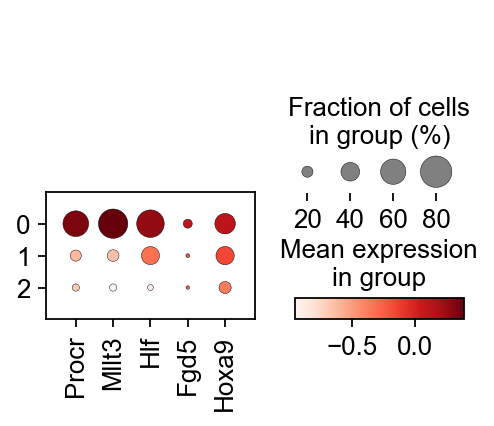

In [1218]:
# hs and progen
sc.pl.rank_genes_groups_dotplot(adONorm, var_names = hs_genes, groupby='leiden',use_raw=False, dendrogram=False)
# 0 aka blue branch looks like the hsc

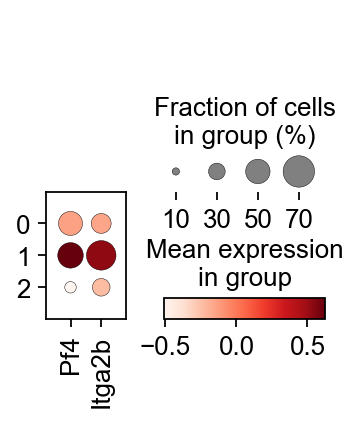

In [1219]:
# meg progen
sc.pl.rank_genes_groups_dotplot(adONorm, var_names = meg_genes, groupby='leiden',use_raw=False, dendrogram=False)
# 1 aka orange branch looks like meg

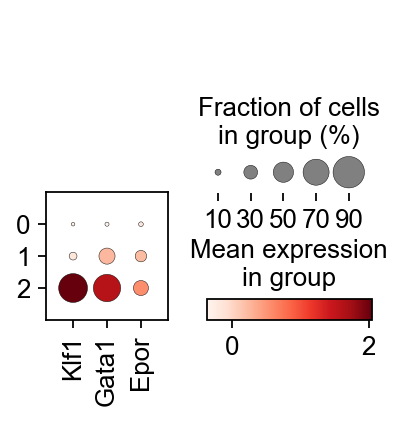

In [1220]:
# eryth progen
sc.pl.rank_genes_groups_dotplot(adONorm, var_names = eryth_genes, groupby='leiden',use_raw=False, dendrogram=False)
# 2 aka green branch looks like eryth

In [1221]:
# rename leidens to what we think they are 
new_sc_names = ['HS', 'Meg', 'Eryth']
adONorm.rename_categories('leiden', new_sc_names)

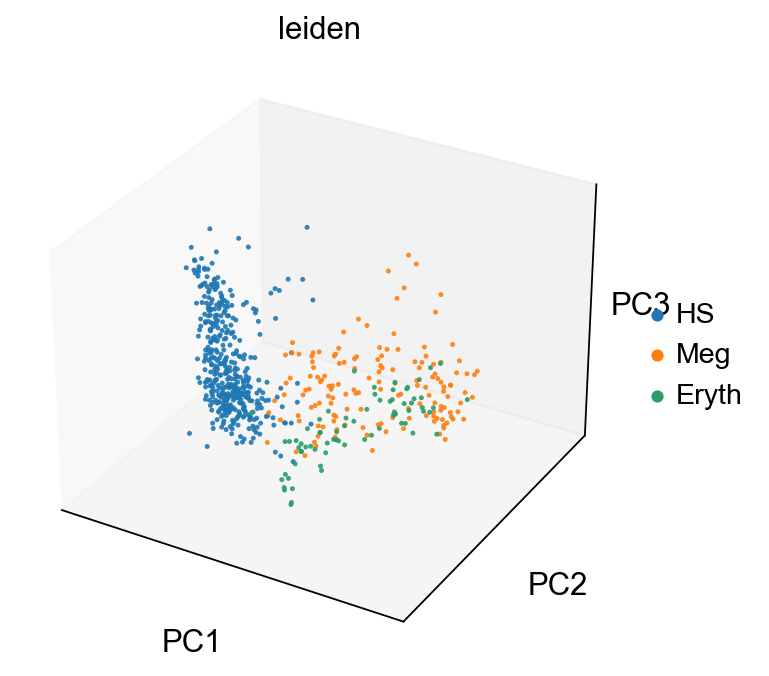

In [1222]:
# 3d pca colored by leiden
sc.pl.pca(adONorm, color=["leiden"], alpha=.9, s=25, projection='3d')

In [1223]:
# compute paga
sc.tl.paga(adONorm, groups='leiden')

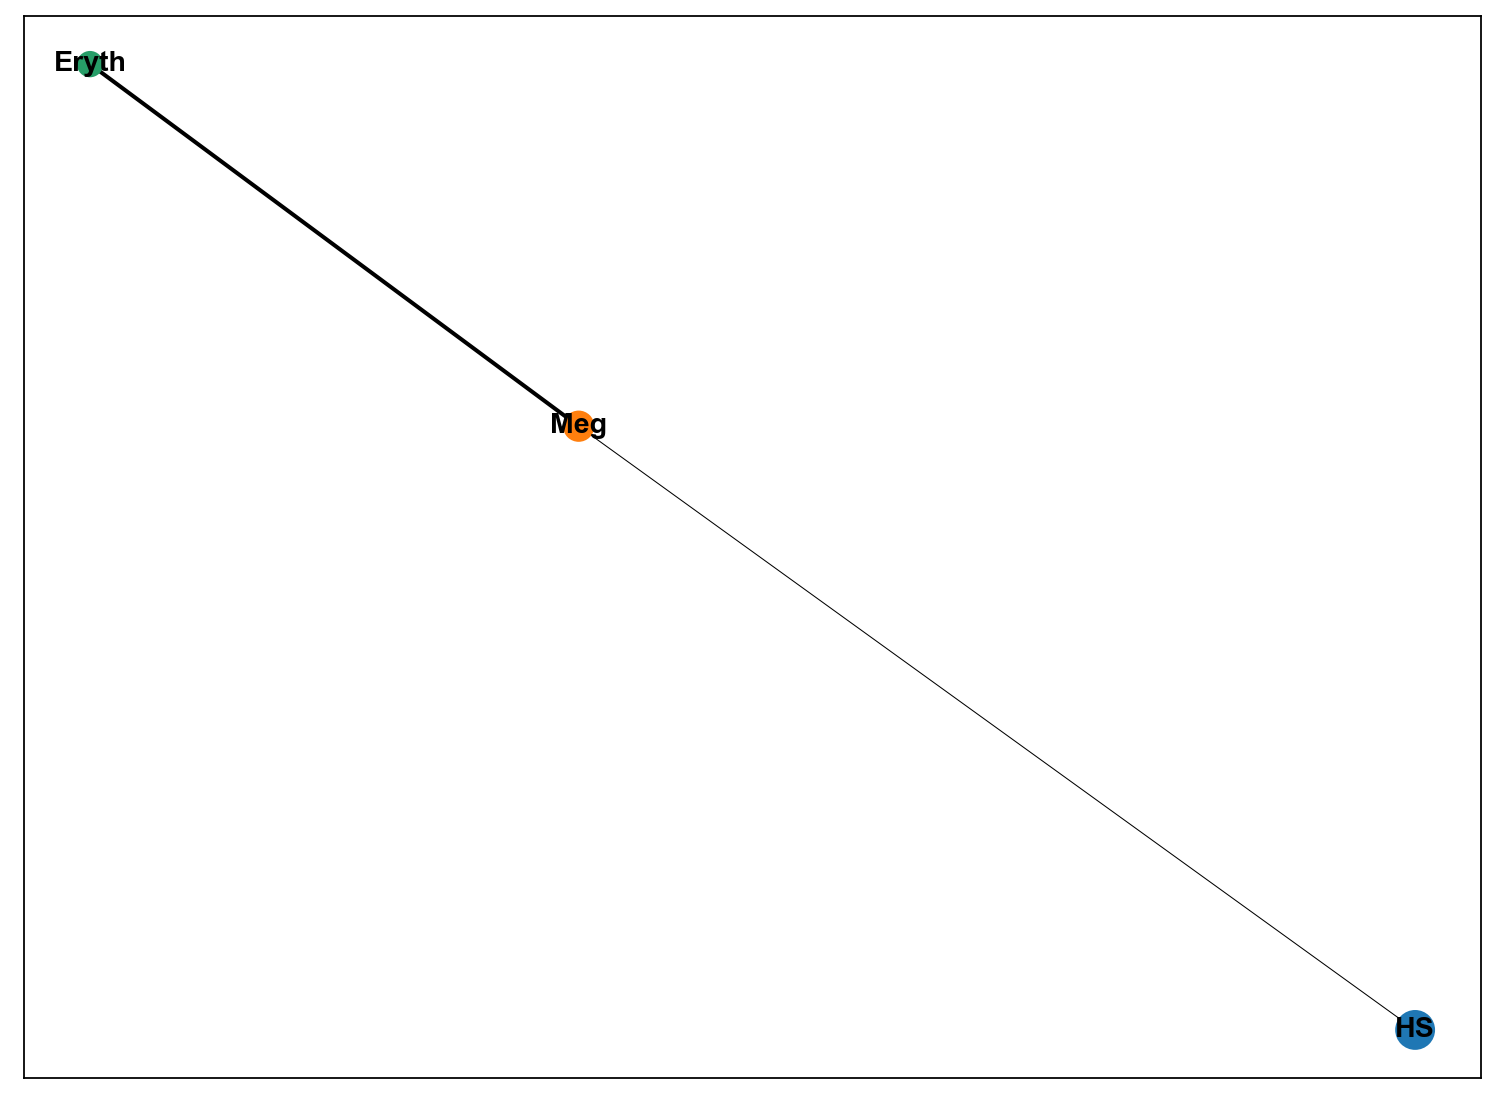

In [1224]:
# plot paga
sc.set_figure_params(figsize="10, 8")
sc.pl.paga(adONorm, color=['leiden'])

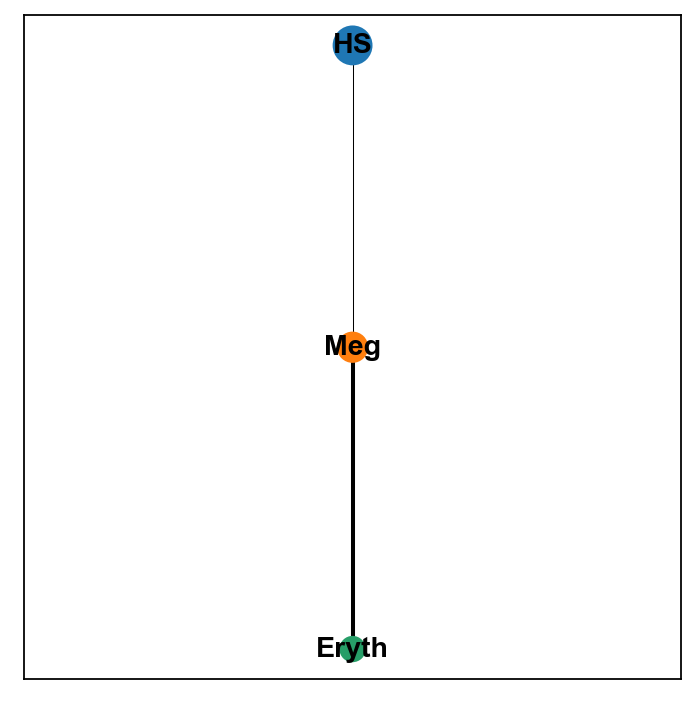

In [1225]:
# plot reoriented paga
sc.set_figure_params(figsize="5, 5")
sc.pl.paga(adONorm,color=['leiden'], layout="rt", root=0, single_component=True)

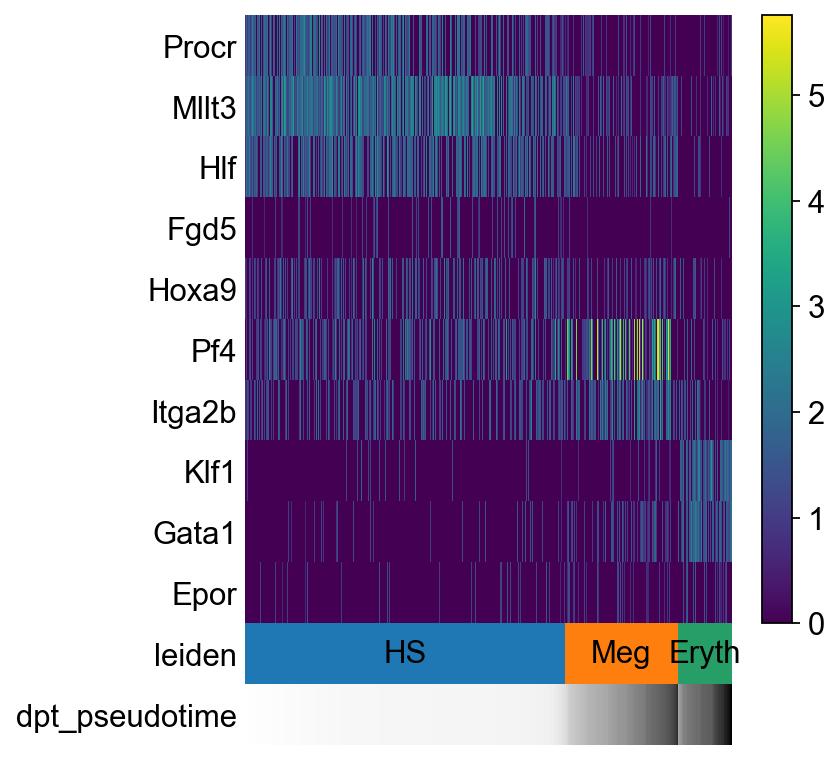

In [1226]:
# paga path with genes of interest to view differntial expression across groups
sc.pl.paga_path(adONorm, [0, 1, 2], keys=hs_genes + meg_genes + eryth_genes)

In [1227]:
# score cells with our genesets 
sc.tl.score_genes(adONorm, gene_list = hs_genes, score_name = "hs_genesets", use_raw=False)
sc.tl.score_genes(adONorm, gene_list = meg_genes, score_name = "meg_genesets", use_raw=False)
sc.tl.score_genes(adONorm, gene_list = eryth_genes, score_name = "eryth_genesets", use_raw=False)

In [1228]:
adONorm.obs

age sample              cellid  n_genes_by_counts  \
AAACCTGGTCCGAGTC-1  old  old_A  AAACCTGGTCCGAGTC-1               1774   
AAAGCAAAGGAGTACC-1  old  old_A  AAAGCAAAGGAGTACC-1               3616   
AAAGCAACATTAGGCT-1  old  old_A  AAAGCAACATTAGGCT-1               3581   
AAAGCAAGTCCGAGTC-1  old  old_A  AAAGCAAGTCCGAGTC-1               2520   
AAAGCAATCGCAAGCC-1  old  old_A  AAAGCAATCGCAAGCC-1               3299   
...                 ...    ...                 ...                ...   
TTTGCGCGTGTAATGA-1  old  old_A  TTTGCGCGTGTAATGA-1               1985   
TTTGCGCGTTTGGGCC-1  old  old_A  TTTGCGCGTTTGGGCC-1               3479   
TTTGGTTGTACGAAAT-1  old  old_A  TTTGGTTGTACGAAAT-1               1943   
TTTGGTTGTTACGCGC-1  old  old_A  TTTGGTTGTTACGCGC-1               4530   
TTTGTCAGTATAGTAG-1  old  old_A  TTTGTCAGTATAGTAG-1               1801   

                    total_counts  total_counts_ribo  pct_counts_ribo  \
AAACCTGGTCCGAGTC-1        3765.0              974.0        25.869856   
AAAGCAAAGGAGTACC-1       11348.0             3617.0        31.873459   
AAAGCAACATTAGGCT-1       10741.0             2913.0        27.120378   
AAAGCAAGTCCGAGTC-1        8516.0             3241.0        38.057774   
AAAGCAATCGCAAGCC-1        9745.0             2701.0        27.716776   
...                          ...                ...              ...   
TTTGCGCGTGTAATGA-1        4815.0             1686.0        35.015575   
TTTGCGCGTTTGGGCC-1       10411.0             2596.0        24.935165   
TTTGGTTGTACGAAAT-1        4387.0             1307.0        29.792568   
TTTGGTTGTTACGCGC-1       16464.0             4942.0        30.017006   
TTTGTCAGTATAGTAG-1        4026.0             1153.0        28.638849   

                    total_counts_mt  pct_counts_mt  n_counts leiden  \
AAACCTGGTCCGAGTC-1             61.0       1.620186    2697.0    Meg   
AAAGCAAAGGAGTACC-1            319.0       2.811068    7272.0     HS   
AAAGCAACATTAGGCT-1            219.0       2.038916    7543.0    Meg   
AAAGCAAGTCCGAGTC-1            202.0       2.372005    5056.0  Eryth   
AAAGCAATCGCAAGCC-1            318.0       3.263212    6646.0    Meg   
...                             ...            ...       ...    ...   
TTTGCGCGTGTAATGA-1            161.0       3.343717    2869.0     HS   
TTTGCGCGTTTGGGCC-1            311.0       2.987225    7465.0    Meg   
TTTGGTTGTACGAAAT-1            121.0       2.758149    2872.0     HS   
TTTGGTTGTTACGCGC-1            574.0       3.486394   10645.0     HS   
TTTGTCAGTATAGTAG-1            188.0       4.669647    2619.0     HS   

                    dpt_pseudotime dpt_groups  dpt_order  dpt_order_indices  \
AAACCTGGTCCGAGTC-1        0.425487          0        479                  1   
AAAGCAAAGGAGTACC-1        0.000000          0          0                626   
AAAGCAACATTAGGCT-1        0.441289          0        491                373   
AAAGCAAGTCCGAGTC-1        0.698075          0        609                134   
AAAGCAATCGCAAGCC-1        0.435133          0        485                140   
...                            ...        ...        ...                ...   
TTTGCGCGTGTAATGA-1        0.089543          0        362                217   
TTTGCGCGTTTGGGCC-1        0.427806          0        480                145   
TTTGGTTGTACGAAAT-1        0.074820          0        215                375   
TTTGGTTGTTACGCGC-1        0.063844          0        153                438   
TTTGTCAGTATAGTAG-1        0.074890          0        216                317   

                    hs_genesets  meg_genesets  eryth_genesets  
AAACCTGGTCCGAGTC-1    -0.298947     -0.495105       -0.378640  
AAAGCAAAGGAGTACC-1    -0.020600     -0.351313       -0.428633  
AAAGCAACATTAGGCT-1    -0.222486      0.915612       -0.436572  
AAAGCAAGTCCGAGTC-1    -0.525813     -0.746388        1.428613  
AAAGCAATCGCAAGCC-1    -0.212361     -0.383009       -0.085331  
...                         ...           ...             ...  
TTTGCGCGTGTAATGA-1     0.860

In [1229]:
# mean gene scores for each geneset for each leiden classification 
# each classifcation has highest mean score for their correspoding geneset
# this provide support for our labeling as our labels each have the highest score for their corresponding gene sets 
# which means expression of those selected genes in that corresponding geneset is higher than the others
adONorm.obs.groupby('leiden').agg({'hs_genesets':'mean', 'meg_genesets':'mean', 'eryth_genesets':'mean'})

hs_genesets  meg_genesets  eryth_genesets
leiden                                           
HS         0.245558     -0.139362       -0.256465
Meg       -0.414763      0.541449        0.046647
Eryth     -0.589097     -0.307960        1.426448

In [1230]:
# read in cell cycle genes from hw 2
cell_cycle_genes = [x.strip() for x in open("mouseCellCycle_050218.csv")]

# classify cell cycle genes for each part of the cell cycle
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]

# now intersect these with genes present in the annData object
cell_cycle_genes = [x for x in cell_cycle_genes if x in adONorm.var_names]
print("n cc genes:", len(cell_cycle_genes))

n cc genes: 109


In [1231]:
# reassign the genes for only the one present in the data
s_genes = [x for x in s_genes if x in adONorm.var_names]
g2m_genes = [x for x in g2m_genes if x in adONorm.var_names]

In [1232]:
# score the genes based on these seperated cell cycle genes 
sc.tl.score_genes_cell_cycle(adONorm, s_genes = s_genes, g2m_genes = g2m_genes, use_raw = False)

In [1233]:
# print number of each classifcation and cell cycle stage
print('HS and G1:', len(adONorm.obs[(adONorm.obs['phase'] =='G1') & (adONorm.obs['leiden'] == 'HS')]))
print('HS and S:', len(adONorm.obs[(adONorm.obs['phase'] =='S') & (adONorm.obs['leiden'] == 'HS')]))
print('HS and G2M:', len(adONorm.obs[(adONorm.obs['phase'] =='G2M') & (adONorm.obs['leiden'] == 'HS')]))

print('Meg and G1:', len(adONorm.obs[(adONorm.obs['phase'] =='G1') & (adONorm.obs['leiden'] == 'Meg')]))
print('Meg and S:', len(adONorm.obs[(adONorm.obs['phase'] =='S') & (adONorm.obs['leiden'] == 'Meg')]))
print('Meg and G2M:', len(adONorm.obs[(adONorm.obs['phase'] =='G2M') & (adONorm.obs['leiden'] == 'Meg')]))

print('Eryth and G1:', len(adONorm.obs[(adONorm.obs['phase'] =='G1') & (adONorm.obs['leiden'] == 'Eryth')]))
print('Eryth and S:', len(adONorm.obs[(adONorm.obs['phase'] =='S') & (adONorm.obs['leiden'] == 'Eryth')]))
print('Eryth and G2M:', len(adONorm.obs[(adONorm.obs['phase'] =='G2M') & (adONorm.obs['leiden'] == 'Eryth')]))

HS and G1: 380
HS and S: 39
HS and G2M: 3
Meg and G1: 7
Meg and S: 83
Meg and G2M: 59
Eryth and G1: 15
Eryth and S: 44
Eryth and G2M: 12


## Differences between young and old

In [1248]:
# lets look at proportion of cell types present for each dataset
# young
print('Young, % of cells that are:')
print('Type:')
print('HS and progens:', len(adYNorm.obs[adYNorm.obs['leiden'] == 'HS'])/len(adYNorm.obs)*100, '%')
print('Meg progens:', len(adYNorm.obs[adYNorm.obs['leiden'] == 'Meg'])/len(adYNorm.obs)*100, '%')
print('Eryth progens:', len(adYNorm.obs[adYNorm.obs['leiden'] == 'Eryth'])/len(adYNorm.obs)*100, '%')

# lets all look at cell cycle percents
print('')
print('Cell Cycle:')
print('G1:', len(adYNorm.obs[adYNorm.obs['phase'] == 'G1'])/len(adYNorm.obs)*100, '%')
print('S:', len(adYNorm.obs[adYNorm.obs['phase'] == 'S'])/len(adYNorm.obs)*100, '%')
print('G2M:', len(adYNorm.obs[adYNorm.obs['phase'] == 'G2M'])/len(adYNorm.obs)*100, '%')

Young, % of cells that are:
Type:
HS and progens: 40.41450777202073 %
Meg progens: 35.49222797927461 %
Eryth progens: 24.093264248704664 %

Cell Cycle:
G1: 39.119170984455955 %
S: 38.34196891191709 %
G2M: 22.53886010362694 %


In [1247]:
# old
print('Old, % of cells that are:')
print('Type:')
print('HS and progens:', len(adONorm.obs[adONorm.obs['leiden'] == 'HS'])/len(adONorm.obs)*100, '%')
print('Meg progens:', len(adONorm.obs[adONorm.obs['leiden'] == 'Meg'])/len(adONorm.obs)*100, '%')
print('Eryth progens:', len(adONorm.obs[adONorm.obs['leiden'] == 'Eryth'])/len(adONorm.obs)*100, '%')

# lets all look at cell cycle percents
print('')
print('Cell Cycle:')
print('G1:', len(adONorm.obs[adONorm.obs['phase'] == 'G1'])/len(adONorm.obs)*100, '%')
print('S:', len(adONorm.obs[adONorm.obs['phase'] == 'S'])/len(adONorm.obs)*100, '%')
print('G2M:', len(adONorm.obs[adONorm.obs['phase'] == 'G2M'])/len(adONorm.obs)*100, '%')

Old, % of cells that are:
Type:
HS and progens: 65.73208722741433 %
Meg progens: 23.20872274143302 %
Eryth progens: 11.059190031152648 %

Cell Cycle:
G1: 62.616822429906534 %
S: 25.85669781931464 %
G2M: 11.526479750778815 %


From above, we can see that old mice have alot more HS and progen cells and less meg/eryth progens. This definitely contributes to why old mice have less erythroid cells because without erythroid progenitors we do not get erythroid cells. We can also see that old mice have more cells in the G1 phase of the cell cycle. Which means more of their cells are NOT replicating DNA and going through mitosis. I think that as mice get older their erythroid cells start dying off (normal aging process) and they are also not replicating as much, so that is why they have a lower number of erythroid cells vs young mice. The branches in our diff map represent cells that are 'moving' or transitioning towards that cell type (the ones we labeled them as).